# TVB-NEST: Bridging multiscale activity by co-simulation

## Step-by-step learn how to perform a co-simulation embedding spiking neural networks into large-scale brain networks using TVB.

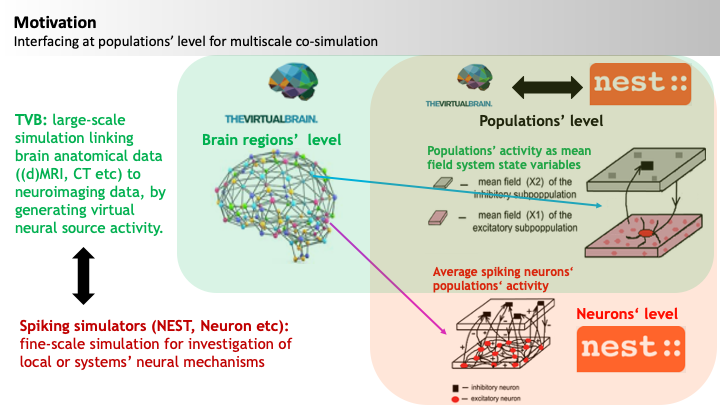

In [1]:
from IPython.core.display import Image, display
display(Image(filename='../pics/ConceptGraph1.png',  width=1000, unconfined=False))

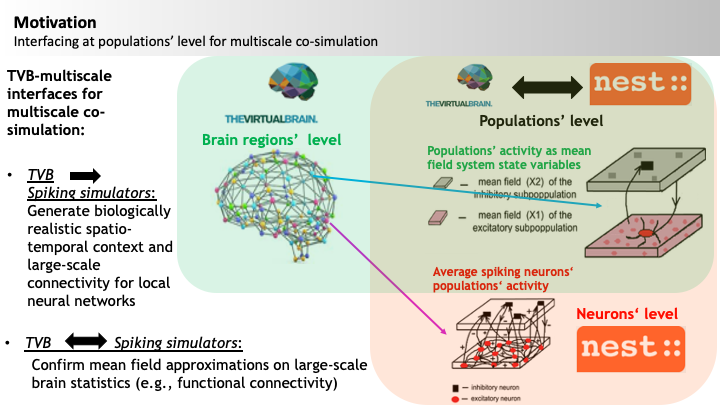

In [2]:
display(Image(filename='../pics/ConceptGraph2.png',  width=1000, unconfined=False))

## tvb-multiscale toolbox:

### https://github.com/the-virtual-brain/tvb-multiscale

For questions use the git issue tracker, or write an e-mail to me: dionysios.perdikis@charite.de

# TVB - NEST co-simulation 

## Wilson - Cowan TVB mean field model

For every region node $n\prime$ modelled as a mean-field node in TVB:

Population activity dynamics (1 excitatory and 1 inhibitory population):

 $\dot{E}_k = \dfrac{1}{\tau_e} (-E_k  + (k_e - r_e E_k) \mathcal{S}_e (\alpha_e \left( c_{ee} E_k - c_{ei} I_k  + P_k - \theta_e + \mathbf{\Gamma}(E_k, E_j, u_{kj}) + W_{\zeta}\cdot E_j + W_{\zeta}\cdot I_j\right) )) $
 
$
            \dot{I}_k = \dfrac{1}{\tau_i} (-I_k  + (k_i - r_i I_k) \mathcal{S}_i (\alpha_i \left( c_{ie} E_k - c_{ee} I_k  + Q_k - \theta_i + \mathbf{\Gamma}(E_k, E_j, u_{kj}) + W_{\zeta}\cdot E_j + W_{\zeta}\cdot I_j\right) ))$


## Spiking network model in NEST

using "iaf_cond_alpha" spiking neuronal model.

## TVB to NEST coupling
TVB couples to NEST via instantaneous spike rate $ w_{TVB->NEST} * E(t) $, 

Inhomogeneous spike generator NEST devices are used as TVB "proxy" nodes and generate independent Poisson-random spike trains 

$ \left[ \sum_k \delta(t-\tau_{n\prime n}-{t_j}^k) \right]_{j \in n\prime} $

Alternatively, the spike trains are generated outside NEST using the Elephant software and inserted to NEST via spike generator devices.



## NEST to TVB update

A NEST spike detector device is used to count spike for each time step, and convert it to an instantaneous population mean rate that overrides

$ {E_{_{n}}}(t) =  \frac{\sum_j\left[ \sum_k \delta(t-\tau_n-{t_j}^k) \right]_{j \in E_n}}{N_E * dt} $ 

$ {I_{_{n}}}(t) =  \frac{\sum_j\left[ \sum_k \delta(t-\tau_n-{t_j}^k) \right]_{j \in I_n}}{N_I * dt} $

in  spikes/sec.

This update process concerns only the TVB region nodes that are simulated exclusively in NEST, as spiking networks. All the rest of TVB nodes will follow the equations of the mean field model described above.


## Simulator loop

### Simulating several (i.e., minimally 2) NEST time steps for every 1 TVB time step for stable integration

### Synchronizaion every minimum delay time between the two simulators.

# WORKFLOW:

In [3]:
import os
from collections import OrderedDict
import time
import numpy as np

from tvb.basic.profile import TvbProfile
TvbProfile.set_profile(TvbProfile.LIBRARY_PROFILE)

from tvb_multiscale.tvb_nest.config import *

# ----------- Simulation options ----------------
CEREB_TO_REST_OF_BRAIN_CONNS_SCALE = 100
STIMULUS = False
WHOLE_BRAIN = False
# WC_MODE = "local" # "local"  or "distributed"
# -----------------------------------------------

if WHOLE_BRAIN:
    BRAIN_CONN_FILE = "Connectivity_res100_596_regions.h5"
    # G = 0.5
else:
    BRAIN_CONN_FILE = "Connectivity_MeanSubcortical.h5" # "Connectivity_SummedSubcortical.h5"", Connectivity_res100_summ49regions_IOsplit.h5"
    # G = 4.0  
    
work_path = os.getcwd()
data_path = os.path.join(work_path.split("tvb_nest")[0], "data", "cerebellum")
tvb_conn_filepath = os.path.join(data_path, BRAIN_CONN_FILE)
outputs_path = os.path.join(work_path, "outputs/cereb_wilson_cowan")
outputs_path += "TVBonly"

config = Config(output_base=outputs_path)
config.figures.SHOW_FLAG = True 
config.figures.SAVE_FLAG = True
config.figures.FIG_FORMAT = 'png'
config.figures.DEFAULT_SIZE= config.figures.NOTEBOOK_SIZE
FIGSIZE = config.figures.DEFAULT_SIZE

from tvb_multiscale.core.plot.plotter import Plotter
plotter = Plotter(config.figures)

# For interactive plotting:
# %matplotlib notebook  

# Otherwise:
%matplotlib inline 

2021-10-11 09:55:42,168 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
2021-10-11 09:55:42,168 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
2021-10-11 09:55:42,171 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2021-10-11 09:55:42,171 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2021-10-11 09:55:42,174 - INFO - tvb_multiscale.tvb_nest.config - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2021-10-11 09:55:42,174 - INFO - tvb_multiscale.tvb_nest.config - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2021-10-11 09:55:42,177 - INFO - tvb_multiscale.tvb_nest.config - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2021-10-11 09:55:42,177 - INFO - tvb_multiscale.tvb_nest.config - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2021-10-11 09:55:42,181 - INFO - tvb_multiscale.tv


## 1. Load structural data <br> (minimally a TVB connectivity)  <br> & prepare TVB simulator  <br> (region mean field model, integrator, monitors etc)

In [4]:
dt = config.DEFAULT_DT  # =0.1

In [5]:

from tvb.basic.neotraits.api import NArray, Attr, Range
from tvb.simulator.coupling import Coupling

class SigmoidalPre(Coupling):
    r"""
    Provides a sigmoidal coupling function of the form

    .. math::
        c_{min} + (c_{max} - c_{min}) / (1.0 + \exp(-a(x-midpoint)/\sigma))

    NB: using a = numpy.pi / numpy.sqrt(3.0) and the default parameter 
        produces something close to the current default for
        Linear (a=0.00390625, b=0) over the linear portion of the sigmoid,
        with saturation at -1 and 1.

    """

    cmin = NArray(
        label=":math:`c_{min}`",
        default=np.array([0.0,]),
        domain=Range(lo=-100.0, hi=100.0, step=1.0),
        doc="""Minimum of the sigmoid function""",)

    cmax = NArray(
        label=":math:`c_{max}`",
        default=np.array([1.0,]),
        domain=Range(lo=-100.0, hi=100.0, step=1.0),
        doc="""Maximum of the sigmoid function""",)

    midpoint = NArray(
        label="midpoint",
        default=np.array([0.0,]),
        domain=Range(lo=-100.0, hi=100.0, step=1.0),
        doc="Midpoint of the linear portion of the sigmoid",)

    a = NArray(
        label=r":math:`a`",
        default=np.array([1.0,]),
        domain=Range(lo=0.1, hi=100.0, step=0.1),
        doc="Scaling of sigmoidal",)

    sigma = NArray(
        label=r":math:`\sigma`",
        default=np.array([20.0,]),
        domain=Range(lo=0.1, hi=100.0, step=0.1),
        doc="Standard deviation of the sigmoidal",)

    parameter_names = 'cmin cmax midpoint a sigma'.split()
    pre_expr =  'cmin + ((cmax - cmin) / (1.0 + exp(-a *((x_j - midpoint) / sigma))))'
    post_expr = 'gx'

    def __str__(self):
        return simple_gen_astr(self, 'cmin cmax midpoint a sigma')

    def pre(self, x_i, x_j):
        return self.cmin + ((self.cmax - self.cmin) / (1.0 + np.exp(-self.a *((x_j - self.midpoint) / self.sigma))))

    def post(self, gx):
        return gx
    

In [6]:
from tvb.simulator.models.base import Model
from tvb.basic.neotraits.api import NArray, Final, List, Range


import queue


class SafeQueue(queue.Queue):
    
    empty_output = np.array([0.0])
    
    def __init__(self, empty_output=np.array([0.0]), *args, **kwargs):
        self.empty_output = empty_output
        super(SafeQueue, self).__init__(*args, **kwargs)
        
    def put_safe(self, item):
        if self.full():
            self.get()
        super(SafeQueue, self).put(item)
        
    def get_safe(self):
        if self.full():
            return self.queue[0]
        else:
            return self.empty_output.copy()
    
    
class WilsonCowanThalamoCortical(Model):
    r"""
    **References**:

    .. [G_2020] Griffiths, J.D. McIntosh, A.R., Lefebvre J. 
       *A Connectome-Based, Corticothalamic Model of State- and Stimulation-Dependent 
       Modulation of Rhythmic Neural Activity and Connectivity*,
       Frontiers in Computational Neuroscience, 14:113, 2020, 
       10.3389/fncom.2020.575143 .

    """

    # Define traited attributes for this model, these represent possible kwargs.
    
    is_cortical = NArray(
        label=":math:`is_cortical`",
        dtype=np.bool,
        default=np.array([True]),
        doc="""Boolean flag vector for cortical regions""")
    
    G = NArray(
        label=":math:`G`",
        default=np.array([5.0]),
        domain=Range(lo=0.0, hi=100.0, step=0.1),
        doc="""Global connectivity scaling factor (g in paper)""")
    
    w_ee = NArray(
        label=":math:`w_{ee}`",
        default=np.array([1.4]),  # 1.4, 0.5
        domain=Range(lo=0.0, hi=2.0, step=0.01),
        doc="""Excitatory - excitatory gain""")

    w_ei = NArray(
        label=":math:`w_{ei}`",
        default=np.array([1.4]),   # 1.4, 1.0
        domain=Range(lo=0.0, hi=2.0, step=0.02),
        doc="""Excitatory - inhibitory gain""")

    w_ie = NArray(
        label=":math:`w_{ie}`",
        default=np.array([-3.0]),  # -3.0, -2.0
        domain=Range(lo=-4.0, hi=0.0, step=0.04),
        doc="""Inhibitory - excitatory gain.""")

    w_ii = NArray(
        label=":math:`w_{ii}`",
        default=np.array([-0.5]),
        domain=Range(lo=-1.0, hi=0.0, step=0.01),
        doc="""Inhibitory - inhibitory gain.""")

    w_er = NArray(
        label=":math:`w_{er}`",
        default=np.array([0.6]),
        domain=Range(lo=0.0, hi=1.0, step=0.02),
        doc="""Excitatory - reticular gain""")

    w_es = NArray(
        label=":math:`w_{es}`",
        default=np.array([0.6]),
        domain=Range(lo=0.0, hi=1.0, step=0.02),
        doc="""Excitatory - relay gain""")

    w_si = NArray(
        label=":math:`w_{si}`",
        default=np.array([0.2]),
        domain=Range(lo=0.0, hi=0.5, step=0.01),
        doc="""Relay - inhibitory gain.""")

    w_se = NArray(
        label=":math:`w_{se}`",
        default=np.array([1.65]),
        domain=Range(lo=0.0, hi=3.0, step=0.05),
        doc="""Relay - excitatory gain.""")
    
    w_rs = NArray(
        label=":math:`w_{rs}`",
        default=np.array([-2.0]),
        domain=Range(lo=-4.0, hi=0.0, step=0.4),
        doc="""Reticular - relay gain.""")
    
    w_sr = NArray(
        label=":math:`w_{sr}`",
        default=np.array([2.0]),
        domain=Range(lo=0.0, hi=4.0, step=0.4),
        doc="""Relay - reticular gain""")
    
    tau_ct = NArray(
        label=r":math:`\tau_{ct}`",
        default=np.array([20.0]),
        domain=Range(lo=0.1, hi=50.0, step=0.1),
        doc="""Thalamocortical time delay [ms]""")
    
    tau_tt = NArray(
        label=r":math:`\tau_{tt}`",
        default=np.array([5.0]),
        domain=Range(lo=0.1, hi=10.0, step=0.1),
        doc="""Intrathalamic time delay [ms]""")
    
    tau_e = NArray(
        label=r":math:`\tau_e`",
        default=np.array([10/0.9]),  # 0.9, 0.5
        domain=Range(lo=0.1, hi=10.0, step=0.1),
        doc="""Cortical excitatory population time constant (1/a_e in paper) [ms]""")

    tau_i = NArray(
        label=r":math:`\tau_i`", 
        default=np.array([10/0.9]), # 0.9, 0.3
        domain=Range(lo=0.1, hi=10.0, step=0.1),
        doc="""Cortical inhibitory population time constant (1/a_i in paper) [ms]""")

    tau_r = NArray(
        label=r":math:`\tau_r`",
        default=np.array([10/0.2]),  # 0.25, 0.2
        domain=Range(lo=0.1, hi=10.0, step=0.1),
        doc="""Thalamic reticular nucleus time constant (1/a_r in paper) [ms]""")
    
    tau_s = NArray(
        label=r":math:`\tau_s`",
        default=np.array([10/0.2]),  # 0.25, 0.2
        domain=Range(lo=0.1, hi=10.0, step=0.1),
        doc="""Thalamic relay nucleus time constant (1/a_s in paper) [ms]""")

    beta = NArray(
        label=":math:`\beta`",
        default=np.array([20.0]),
        domain=Range(lo=0.1, hi=50.0, step=0.1),
        doc="""Activation function gain parameter""")
    
    sigma = NArray(
        label=":math:`\sigma`",
        default=np.array([0.0]),
        domain=Range(lo=-10.0, hi=10.0, step=0.1),
        doc="""Activation function threshold parameter""")
    
    I_e = NArray(
        label=":math:`I_e`",
        default=np.array([-0.35]),
        domain=Range(lo=-1.0, hi=0.0, step=0.05),
        doc="""Cortical excitatory population constant input (i_e in paper)""")
    
    I_i = NArray(
        label=":math:`I_i`",
        default=np.array([-0.3]),
        domain=Range(lo=-1.0, hi=0.0, step=0.05),
        doc="""Cortical inhibitory population constant input (i_i in paper)""")
    
    I_r = NArray(
        label=":math:`I_r`",
        default=np.array([-0.8]),
        domain=Range(lo=-1.5, hi=0.0, step=0.05),
        doc="""Thalamic reticular nucleus constant input (i_r in paper)""")
    
    I_s = NArray(
        label=":math:`I_s`",
        default=np.array([0.5]),
        domain=Range(lo=0.0, hi=1.0, step=0.05),
        doc="""Thalamic relay nucleus constant input (i_s in paper)""")
    
    I_o = NArray(
        label=":math:`I_o",
        default=np.array([0.0]),
        domain=Range(lo=-1.0, hi=1.0, step=0.05),
        doc="""Static sensory/neuromodulatory drive""")
    
    M_e = NArray(
        label=":math:`M_e",
        default=np.array([0.0]),
        domain=Range(lo=0.0, hi=10.0, step=0.01),
        doc="""Amplitude of sinusoidal stimulus to cortical excitatory population""")
    
    M_s = NArray(
        label=":math:`M_s",
        default=np.array([0.0]),
        domain=Range(lo=0.0, hi=10.0, step=0.01),
        doc="""Amplitude of sinusoidal stimulus to thalamic relay population""")
    
    f_e = NArray(
        label=":math:`f_e",
        default=np.array([0.0]),
        domain=Range(lo=0.0, hi=100.0, step=0.1),
        doc="""Frequency of sinusoidal stimulus to cortical excitatory population""")
    
    f_s = NArray(
        label=":math:`f_s",
        default=np.array([0.0]),
        domain=Range(lo=0.0, hi=100.0, step=0.1),
        doc="""Frequency of sinusoidal stimulus to thalamic relay population""")

    # Used for phase-plane axis ranges and to bound random initial() conditions.
    state_variable_range = Final(
        label="State Variable ranges [lo, hi]",
        default={"E": np.array([-1.0, 1.0]),
                 "I": np.array([-1.0, 1.0]), 
                 "R": np.array([-1.0, 1.0]), 
                 "S": np.array([-1.0, 1.0])},
        doc="""The values for each state-variable should be set to encompass
        the expected dynamic range of that state-variable for the current
        parameters, it is used as a mechanism for bounding random inital
        conditions when the simulation isn't started from an explicit history,
        it is also provides the default range of phase-plane plots.""")

    variables_of_interest = List(
        of=str,
        label="Variables watched by Monitors",
        choices=("E", "I", "R", "S"),
        default=("E", "I", "R", "S"),
        doc="""This represents the default state-variables of this Model to be
               monitored. It can be overridden for each Monitor if desired. The
               corresponding state-variable indices for this model are :math:`E = 0`
               and :math:`I = 1`.""")

    state_variables = 'E I R S'.split()
    _nvar = 4
    cvar = np.array([0], dtype=np.int32)        
    stvar = np.array([0, 3], dtype=np.int32)
    
    dt = 0.1
    _n_regions = 1
    _I_so = None
    _et_buffers = None
    _rs_buffers = None
    _sr_buffers = None
    _sc_buffers = None
    _ET_del = None
    _RS_del = None
    _SR_del = None
    _SC_del = None
    
    
    _ET_dels = []
    _RS_dels = []
    _SC_dels = []
    _SR_dels = []
        
    def update_derived_parameters(self):
        self._I_so = self.I_s + self.I_o
        self._n_regions = self.is_cortical.shape[0]
        self.tau_r = self.tau_r.reshape((-1, 1)) * np.ones((self._n_regions, 1))
        self.tau_s = self.tau_s.reshape((-1, 1)) * np.ones((self._n_regions, 1))
        self.tau_ct = self.tau_ct.reshape((-1, 1)) * np.ones((self._n_regions, 1))
        self.tau_tt = self.tau_tt.reshape((-1, 1)) * np.ones((self._n_regions, 1))
        is_subcortical = np.logical_not(self.is_cortical)
        self.tau_r[is_subcortical] = 1.0
        self.tau_s[is_subcortical] = 1.0
        n_delay_steps_ct = (1 + np.round(self.tau_ct / self.dt)).astype('i')
        n_delay_steps_tt = (1 + np.round(self.tau_tt / self.dt)).astype('i')
        dummy = np.zeros((1, self.number_of_modes)).astype('f')
        self._et_buffers = []
        self._sc_buffers = []
        self._rs_buffers = []
        self._sr_buffers = []
        for iR in range(self._n_regions):
            if self.is_cortical[iR]:
                self._et_buffers.append(SafeQueue(dummy.copy(), n_delay_steps_ct[iR]))
                self._rs_buffers.append(SafeQueue(dummy.copy(), n_delay_steps_tt[iR]))
                self._sr_buffers.append(SafeQueue(dummy.copy(), n_delay_steps_tt[iR]))
                self._sc_buffers.append(SafeQueue(dummy.copy(), n_delay_steps_ct[iR]))
        self._ET_del = np.zeros((self._n_regions, self.number_of_modes))
        self._RS_del = np.zeros((self._n_regions, self.number_of_modes))
        self._SR_del = np.zeros((self._n_regions, self.number_of_modes))
        self._SC_del = np.zeros((self._n_regions, self.number_of_modes))
        self.M_e = self.M_e.reshape((-1, 1)) * np.ones((self._n_regions, 1))
        self.M_s = self.M_s.reshape((-1, 1)) * np.ones((self._n_regions, 1))
        self.f_e = self.f_e.reshape((-1, 1)) * np.ones((self._n_regions, 1))
        self.f_s = self.f_s.reshape((-1, 1)) * np.ones((self._n_regions, 1))
        self._M_s = self.M_s.copy()
        self._M_s[is_subcortical] = 0.0
        self._stim_e = np.zeros((self._n_regions, self.number_of_modes))
        self._stim_s = np.zeros((self._n_regions, self.number_of_modes))
        self._stim_e_inds = self.M_e != 0.0
        self._stim_s_inds = np.logical_and(self._M_s != 0.0, self.is_cortical)
        self._M_e = self.M_e[self._stim_e_inds]
        self._M_s = self._M_s[self._stim_s_inds]
        self._omega_e = 2*np.pi/1000 * self.f_e[self._stim_e_inds]  # convert f to angular frequenc omega...
        self._omega_s = 2*np.pi/1000 * self.f_s[self._stim_s_inds]  # ...and time for ms to sec
            
    def sigm_activ(self, x):
        return 1/(1 + np.exp(-self.beta*(x - self.sigma)))
    
    def _get_from_buffers(self, buffers):
        output = []
        for buffer in buffers:
            output.append(buffer.get_safe())
        return np.concatenate(output)
        
    def __ET_del(self):
        return self._get_from_buffers(self._et_buffers)
    
    def __RS_del(self):
        return self._get_from_buffers(self._rs_buffers)
        
    def __SR_del(self):
        return self._get_from_buffers(self._sr_buffers)
        
    def __SC_del(self):
        return self._get_from_buffers(self._sc_buffers)
    
    def _update_buffers(self, items, buffers):
        for item, buffer in zip(items, buffers):
            buffer.put_safe(item.reshape((-1,1)))
    
    def _update_E(self, E):
        self._update_buffers(E, self._et_buffers)
    
    def _update_R(self, R):
        self._update_buffers(R, self._rs_buffers)
        
    def _update_S(self, S):
        self._update_buffers(S, self._sr_buffers)
        self._update_buffers(S, self._sc_buffers)
        
    def update_state_variables_before_integration(self, state_variables, coupling, 
                                                  local_coupling=0.0, stimulus=0.0, time=0.0):
        # This is executed only once for each time step
        # at the beginning of the integration schema computation 
        
        E = state_variables[0] # exc
        
        # Update buffers with new input state
        self._update_E(E[self.is_cortical[:, 0]]) # exc
        self._update_R(state_variables[2, self.is_cortical[:, 0]]) # thal reticular
        self._update_S(state_variables[3, self.is_cortical[:, 0]]) # thal relay 
        
        # Get the new delayed state for local thalamocortical and intrathalamic couplings
        self._ET_del[self.is_cortical[:, 0]] = self.__ET_del() # cortical exc to thalamus delayed coupling
        self._RS_del[self.is_cortical[:, 0]] = self.__RS_del() # thalamic rtn to thalamic relay delayed coupling
        self._SC_del[self.is_cortical[:, 0]] = self.__SC_del() # thalamic relay to cortex exc and inh delayed coupling
        self._SR_del[self.is_cortical[:, 0]] = self.__SR_del() # thalamic relay to thalamic rtn delayed coupling

        self._ET_dels.append(self._ET_del.copy())
        self._RS_dels.append(self._RS_del.copy())
        self._SC_dels.append(self._SC_del.copy())
        self._SR_dels.append(self._SR_del.copy())
        
        self._stim_e[self._stim_e_inds] = self._M_e * np.sin(self._omega_e * time)
        self._stim_s[self._stim_s_inds] = self._M_s * np.sin(self._omega_e * time)
        
        return state_variables

#     def update_state_variables_after_integration(self, state_variables, time=0.0):
#         return state_variables
        
    def dfun(self, state_variables, coupling, local_coupling=0.0, time=0.0):
        r"""

        .. math::

        """
        
        E = state_variables[0, :] # exc
        I = state_variables[1, :] # inh
        R = state_variables[2, :] # thal reticular
        S = state_variables[3, :] # thal relay 
        
        # long-range coupling
        c_e = coupling[0, :]  # Cortical exc
        
        derivative = np.empty_like(state_variables)

        derivative[0] = ( -E + \
                          self.w_ee * self.sigm_activ(E) +                   # local cortico-cortical exc -> exc 
                          self.w_ie* self.sigm_activ(I) +                    # local cortico-cortical inh -> exc 
                          np.where(self.is_cortical, 
                                   self.w_se * self.sigm_activ(self._SC_del), # long-range thalamo->cortical relay -> exc
                                   0.0) +                                    # zero for subcortical structures
                          self.G * c_e +                                     # long-range cortico-cortical exc -> exc 
                          self.I_e + self._stim_e ) / self.tau_e

        derivative[1] = ( -I + \
                         self.w_ii * self.sigm_activ(I) +                   # local cortico-cortical inh -> inh 
                         self.w_ei* self.sigm_activ(E) +                    # local cortico-cortical exc -> inh 
                         np.where(self.is_cortical,
                                  self.w_si * self.sigm_activ(self._SC_del), # long-range thalamo->cortical relay -> inh
                                  0.0) +                                    # zero for subcortical structures
                         self.I_i ) / self.tau_i
        
        derivative[2] = ( -R + \
                         np.where(self.is_cortical, 
                                  self.w_er * self.sigm_activ(self._ET_del) +  # cortico-thalamic exc -> reticular 
                                  self.w_sr * self.sigm_activ(self._SR_del) +  # local thalamo-thalamic relay -> reticular
                                  self.I_r, 
                                  0.0) ) / self.tau_r                         # zero for subcortical structures
                        
        
        derivative[3] = ( -S + \
                         np.where(self.is_cortical,  
                                  self.w_es * self.sigm_activ(self._ET_del) +  # cortico-thalamic exc -> relay
                                  self.w_rs * self.sigm_activ(self._RS_del) +  # local thalamo-thalamic reticular -> relay
                                  self._I_so + self._stim_s, 
                                  0.0) ) / self.tau_s                         # zero for subcortical structures
                
        return derivative

/home/docker/env/neurosci/lib/python3.7/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [7]:
import h5py
f = h5py.File(tvb_conn_filepath)
centres=np.array(f["centres"][()]) # hemispheres=np.array(f["hemispheres"][()]), 
region_labels=np.array(f["region_labels"][()]).astype("<U128")
weights=np.array(f["weights"][()])
tract_lengths=np.array(f["tract_lengths"][()]) 
f.close()

for iR, reg_lbl in enumerate(region_labels):
    print("%d. %s" % (iR, reg_lbl))
    

0. Right Frontal pole, cerebral cortex
1. Right Primary motor area
2. Right Secondary motor area
3. Right Primary somatosensory area, nose
4. Right Primary somatosensory area, barrel field
5. Right Primary somatosensory area, lower limb
6. Right Primary somatosensory area, mouth
7. Right Primary somatosensory area, upper limb
8. Right Primary somatosensory area, trunk
9. Right Primary somatosensory area, unassigned
10. Right Supplemental somatosensory area
11. Right Gustatory areas
12. Right Visceral area
13. Right Dorsal auditory area
14. Right Primary auditory area
15. Right Posterior auditory area
16. Right Ventral auditory area
17. Right Anterolateral visual area
18. Right Anteromedial visual area
19. Right Lateral visual area
20. Right Primary visual area
21. Right Posterolateral visual area
22. Right posteromedial visual area
23. Right Laterointermediate area
24. Right Postrhinal area
25. Right Anterior cingulate area, dorsal part
26. Right Anterior cingulate area, ventral part
2

In [8]:
m1_inds = np.array([1, 73])
s1brl_inds = np.array([4, 76])
m1s1brl_inds = np.array(m1_inds.tolist() + s1brl_inds.tolist())
infoliv_inds = np.array([53, 125])
medulla_inds = infoliv_inds.copy()
region_labels[m1s1brl_inds.tolist() + medulla_inds.tolist()]

array(['Right Primary motor area', 'Left Primary motor area',
       'Right Primary somatosensory area, barrel field',
       'Left Primary somatosensory area, barrel field',
       'Right Inferior olivary complex', 'Left Inferior olivary complex'],
      dtype='<U128')

In [9]:
if not WHOLE_BRAIN:
    # ------------------------- For summarized connectivity ------------------------- :
    
    # Find thalamic index:
    thal_ind = len(region_labels)-1
    major_structs_labels = np.load(os.path.join(data_path, "major_structs_labels.npy"))
    crtx_inds = np.where(major_structs_labels == 'Isocortex')[0]
    subcrtx_inds = np.where(major_structs_labels !='Isocortex')[0]
    is_cortical = np.array([False] * region_labels.shape[0]).astype("bool")
    is_cortical[crtx_inds] = True

# ------------------------- For summarized connectivity ------------------------- 

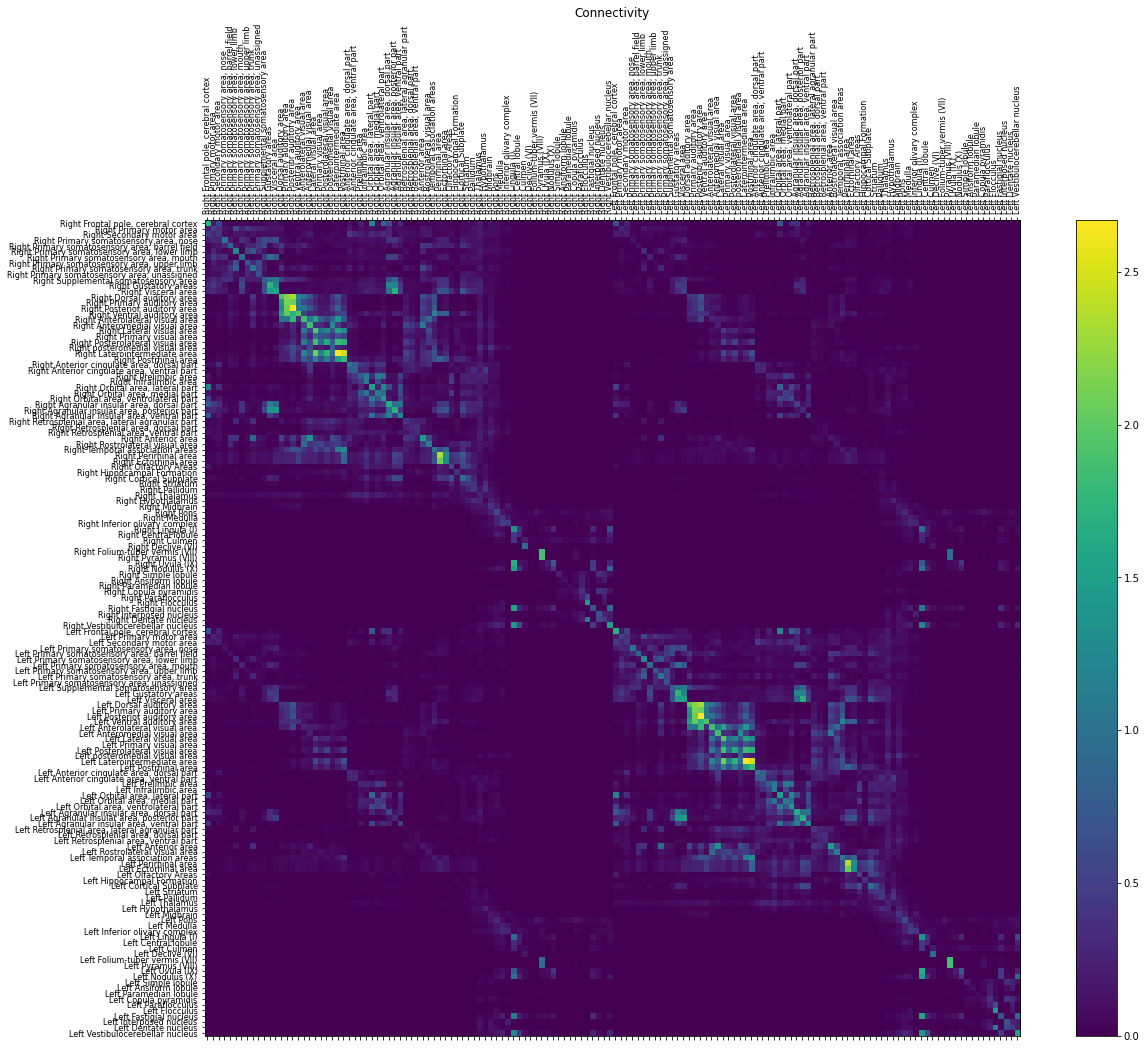

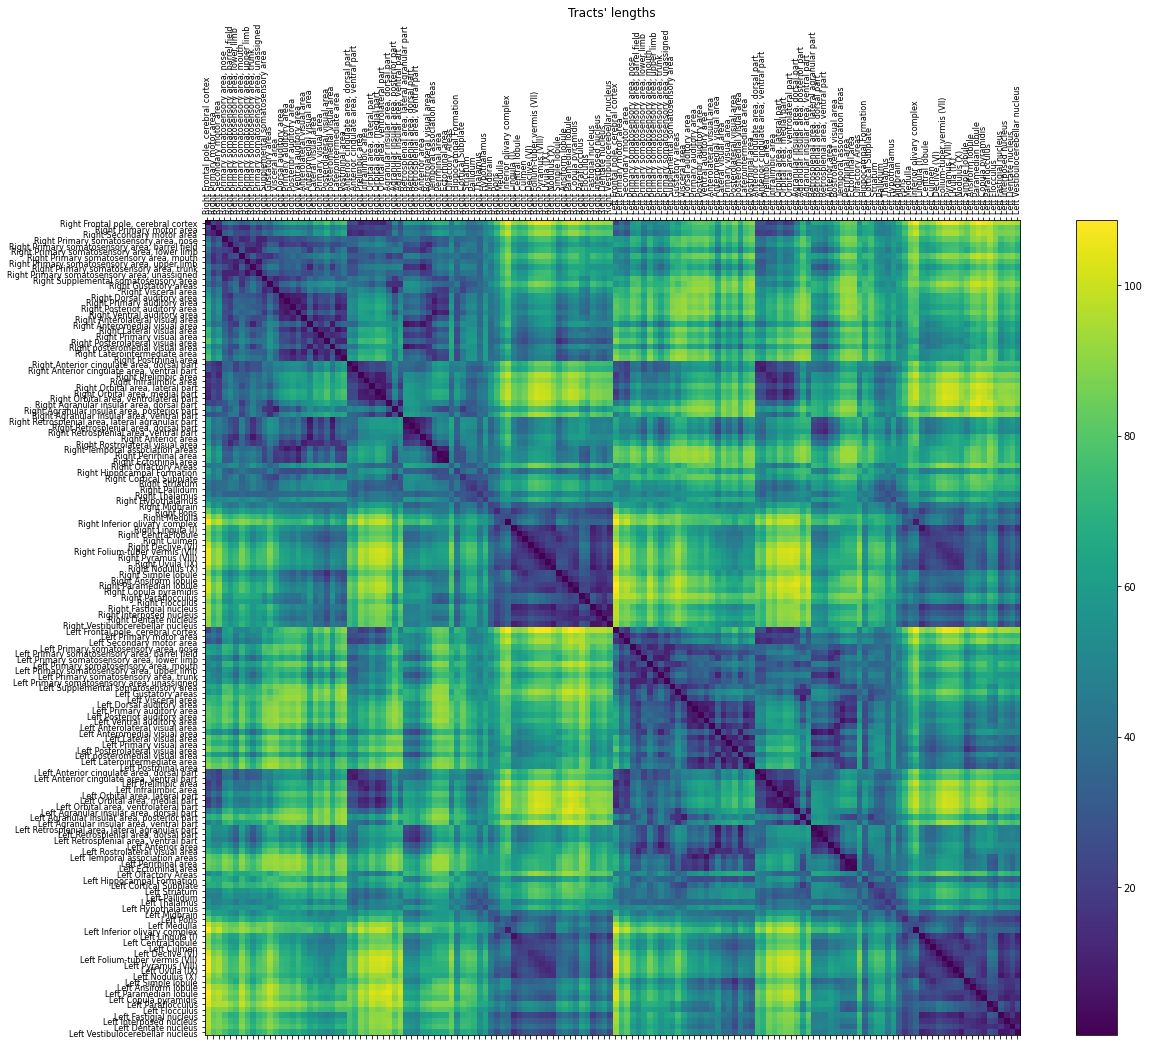

In [10]:
from tvb.datatypes.connectivity import Connectivity

# Load connectivity
# config.DEFAULT_CONNECTIVITY_ZIP = "/home/docker/packages/tvb_data/tvb_data/mouse/allen_2mm/ConnectivityAllen2mm.zip"                                  
# connectivity = Connectivity.from_file(config.DEFAULT_CONNECTIVITY_ZIP)

# Normalize connectivity weights
connectivity = Connectivity(centres=centres, region_labels=region_labels, 
                            weights=weights, tract_lengths=tract_lengths)

connectivity.weights[np.isnan(connectivity.weights)] = 0.0
connectivity.weights = connectivity.scaled_weights(mode="region")
connectivity.weights /= np.percentile(connectivity.weights, 99)
# connectivity.weights[connectivity.weights > 1.0] = 1.0

connectivity.tract_lengths = np.maximum(connectivity.speed * dt, 
                                        connectivity.tract_lengths)

connectivity.configure()

# Plot TVB connectome:
plotter.plot_tvb_connectivity(connectivity);


In [11]:

# -----------------------------------Build cosimulator manually--------------------------------
from tvb_multiscale.core.tvb.cosimulator.cosimulator_serial import CoSimulatorSerial

from tvb.datatypes.equations import Sinusoid
from tvb.simulator.integrators import EulerStochastic # HeunStochastic
from tvb.simulator.monitors import Raw  # , Bold, EEG

simulator = CoSimulatorSerial()

simulator.connectivity = connectivity

M_e = np.zeros((simulator.connectivity.number_of_regions, )).astype("f")
M_e[medulla_inds] = 1.0
f_e = np.zeros((simulator.connectivity.number_of_regions, )).astype("f")
f_e[medulla_inds] = 6.0 # Hz
M_s = np.zeros((simulator.connectivity.number_of_regions, )).astype("f")
M_s[m1_inds] = 1.0
f_s = np.zeros((simulator.connectivity.number_of_regions, )).astype("f")
f_s[m1_inds] = 6.0 # Hz

model_params = {"G": np.array([5.0])/simulator.connectivity.number_of_regions, 
                "M_e": M_e, "M_s": M_s, "f_e": f_e, "f_s": f_s, 
#                 "w_se": np.array([0.0]), "w_si": np.array([0.0]), 
#                 "w_er": np.array([0.0]), "w_es": np.array([0.0])
               }
# if WC_MODE.lower() == "distributed":
#     simulator.model = WilsonCowanThalamoCorticalDistributed(is_thalamic=is_thalamic, **model_params)
# else:

simulator.model = WilsonCowanThalamoCortical(is_cortical=is_cortical[:, np.newaxis], **model_params)
simulator.model.dt = dt

simulator.coupling = SigmoidalPre(sigma=simulator.model.beta,
                                  midpoint=simulator.model.sigma, 
                                  cmin=np.array([0.0]), 
                                  cmax=np.array([1.0]), 
                                  a=np.array([1.0])) 

simulator.integrator = EulerStochastic() # HeunStochastic()
simulator.integrator.dt = dt
simulator.integrator.noise.nsig = np.array([1e-3] * simulator.model.nvar) # config.DEFAULT_NSIG = 0.001

simulator.initial_conditions = np.zeros((1, simulator.model.nvar, connectivity.number_of_regions, 1))

mon_raw = Raw(period=1.0)  # ms
simulator.monitors = (mon_raw, )
simulator.coupling.a = np.array([1.0]) # / 256
simulator.configure()

simulator.integrate_next_step = simulator.integrator.integrate_with_update


## 4. Configure simulator, simulate, gather results

In [12]:
# Simulate!

# For TVB 
# Set the simulation time:
simulation_length =  1100.0
transient = 0.1 * simulation_length    
simulator.simulation_length = simulation_length

tic = time.time()
results = simulator.run()
print("\nSimulated in %f secs!" % (time.time() - tic))



Simulated in 86.038677 secs!


## 5. Plot results and write them to HDF5 files

In [13]:
from scipy.io import savemat
# set to False for faster plotting of only mean field variables and dates, apart from spikes" rasters:
plot_per_neuron = False  
MAX_VARS_IN_COLS = 3
MAX_REGIONS_IN_ROWS = 10
MIN_REGIONS_FOR_RASTER_PLOT = 9
# from examples.plot_write_results import plot_write_results
# plot_write_results(results, simulator, populations=populations, 
#                    transient=transient, tvb_state_variable_type_label="State Variables", 
#                    tvb_state_variables_labels=simulator.model.variables_of_interest, 
#                    plot_per_neuron=plot_per_neuron, plotter=plotter, config=config)

In [14]:
# If you want to see what the function above does, take the steps, one by one
try:
    # We need framework_tvb for writing and reading from HDF5 files
    from tvb_multiscale.tvb.core.io.h5_writer import H5Writer
    writer = H5Writer()
except:
    writer = False
    
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion
from tvb.contrib.scripts.datatypes.time_series_xarray import TimeSeriesRegion as TimeSeriesXarray

# Put the results in a Timeseries instance
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion

source_ts = None
if results is not None:
    source_ts = TimeSeriesXarray(  # substitute with TimeSeriesRegion fot TVB like functionality
            data=results[0][1], time=results[0][0],
            connectivity=simulator.connectivity,
            labels_ordering=["Time", "State Variable", "Region", "Neurons"],
            labels_dimensions={"State Variable": list(simulator.model.variables_of_interest),
                               "Region": simulator.connectivity.region_labels.tolist()},
            sample_period=simulator.integrator.dt)
    source_ts.configure()

    t = source_ts.time

    # Write to file
    if writer:
        writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(source_ts._data,
                                                                        connectivity=source_ts.connectivity),
                               os.path.join(config.out.FOLDER_RES, source_ts.title)+".h5")
    source_ts
    

/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  pyplot.gcf().canvas.set_window_title(figname)
/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  pyplot.gcf().canvas.set_window_title(figname)
/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead

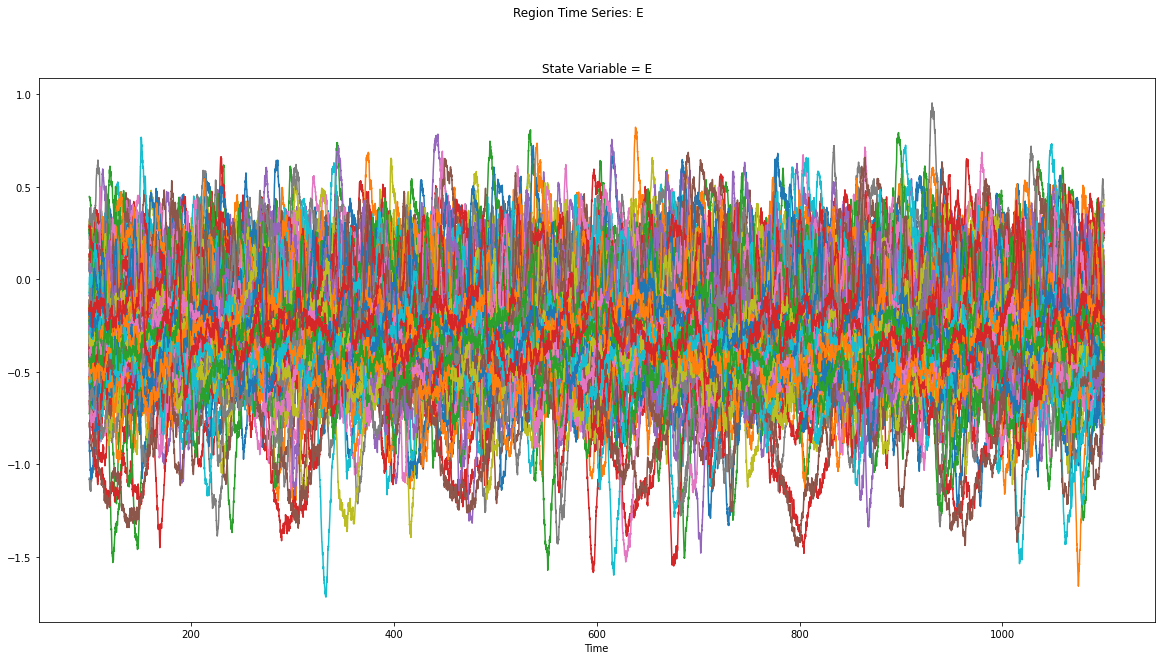

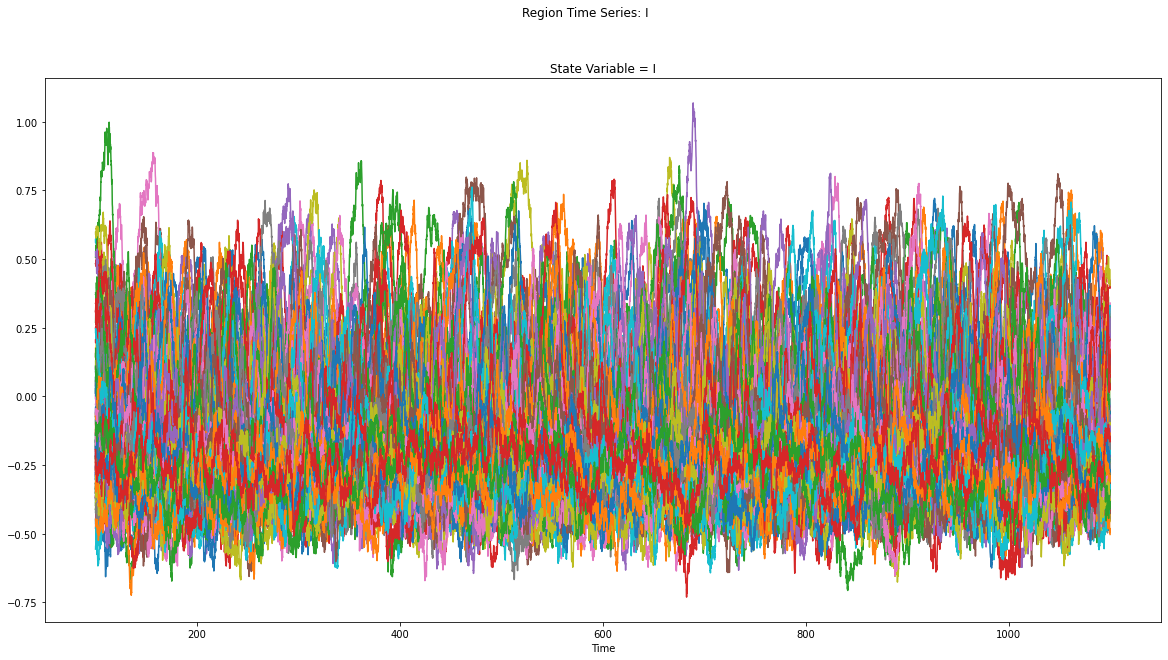

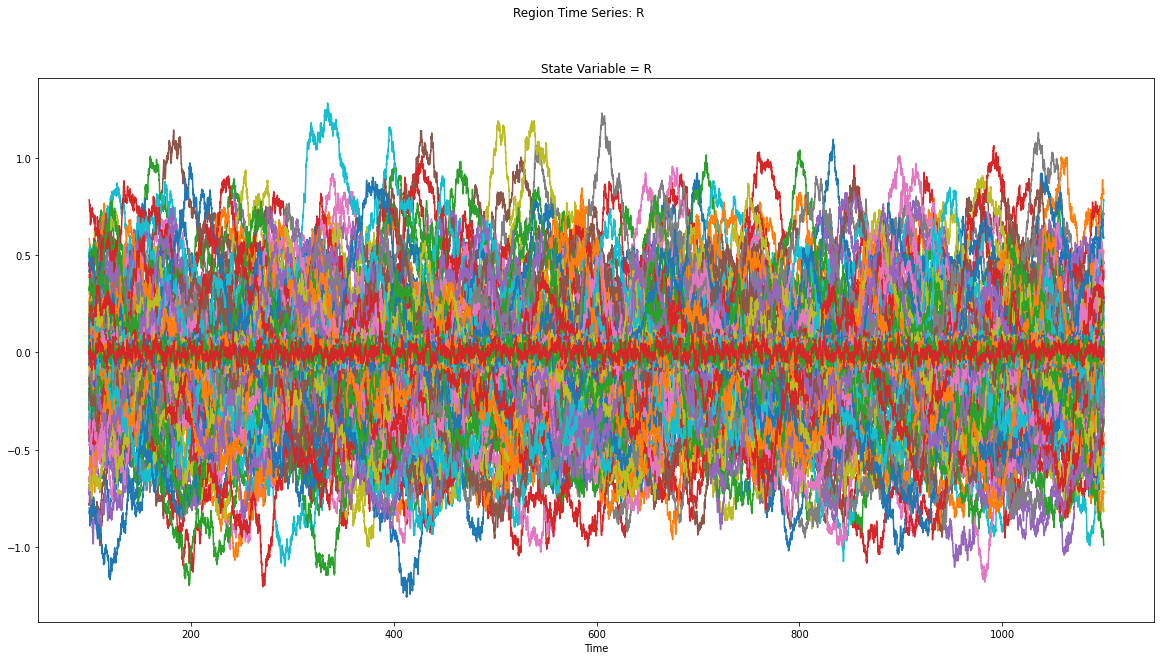

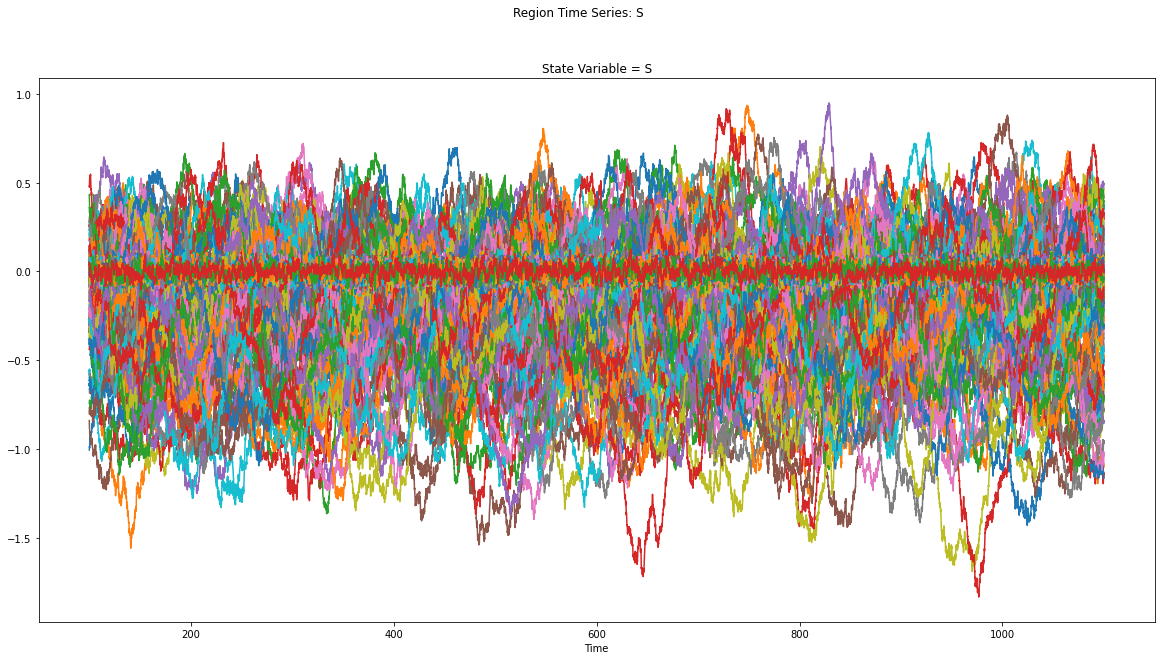

In [15]:
# Plot TVB time series
if source_ts is not None:
    source_ts[-10000:].plot_timeseries(plotter_config=plotter.config, 
                          hue="Region" if source_ts.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                          per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS, 
                          figsize=FIGSIZE);

2021-10-11 09:57:48,687 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-10-11 09:57:48,706 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  pyplot.gcf().canvas.set_window_title(figname)


2021-10-11 09:57:49,163 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  pyplot.gcf().canvas.set_window_title(figname)


2021-10-11 09:57:49,643 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  pyplot.gcf().canvas.set_window_title(figname)


2021-10-11 09:57:50,102 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  pyplot.gcf().canvas.set_window_title(figname)


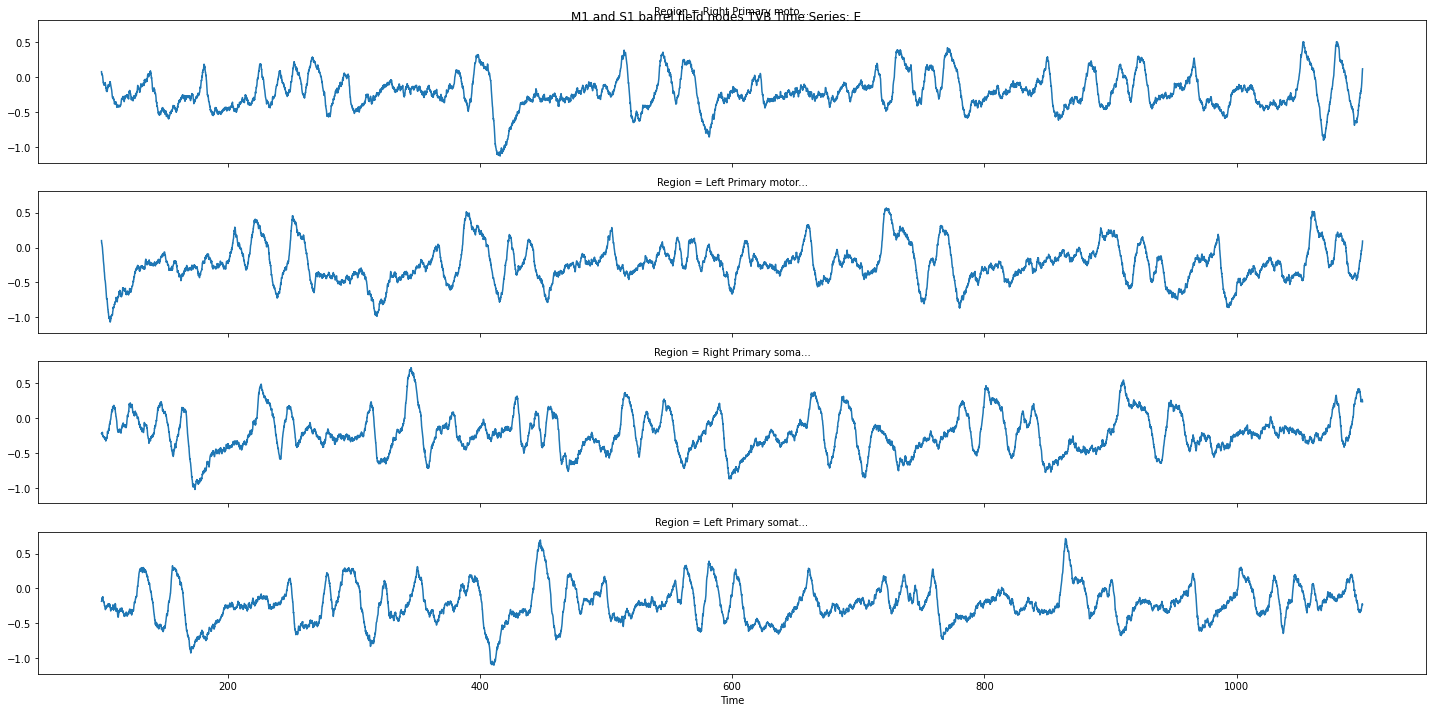

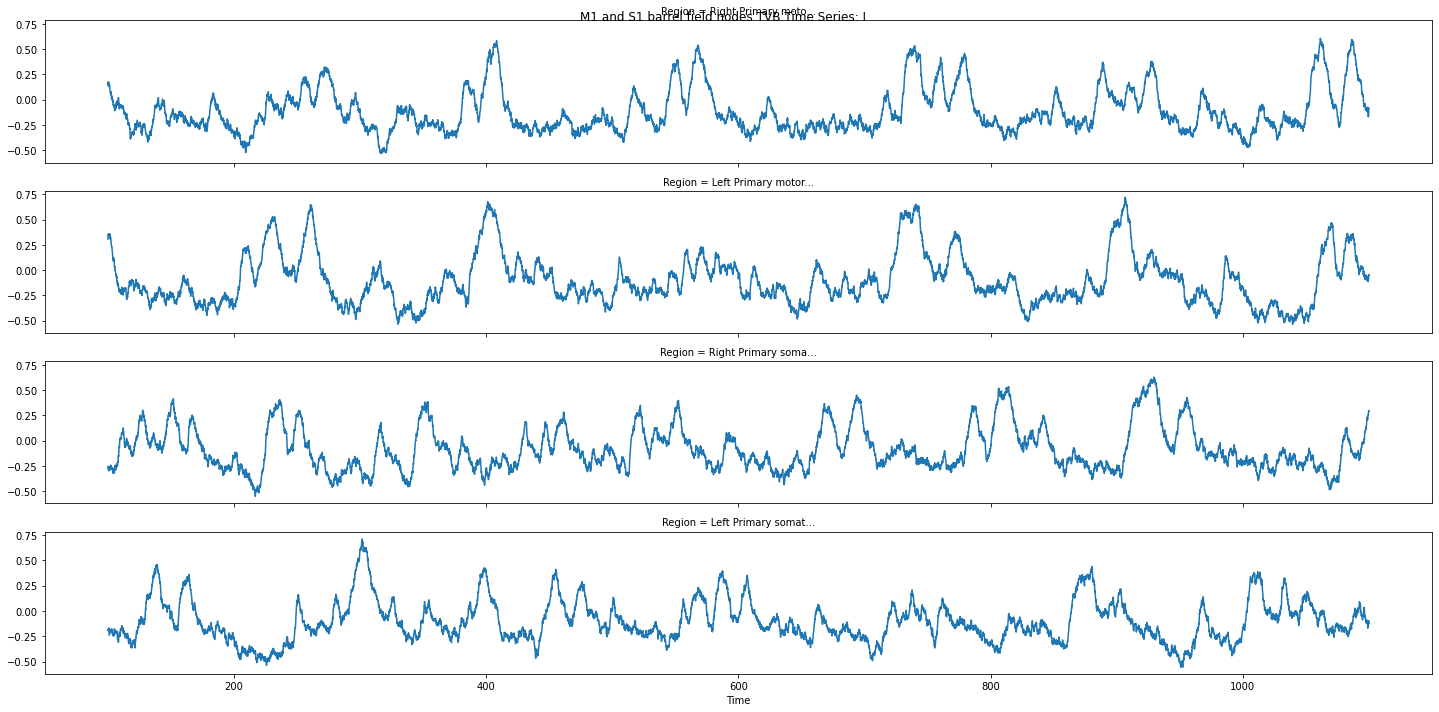

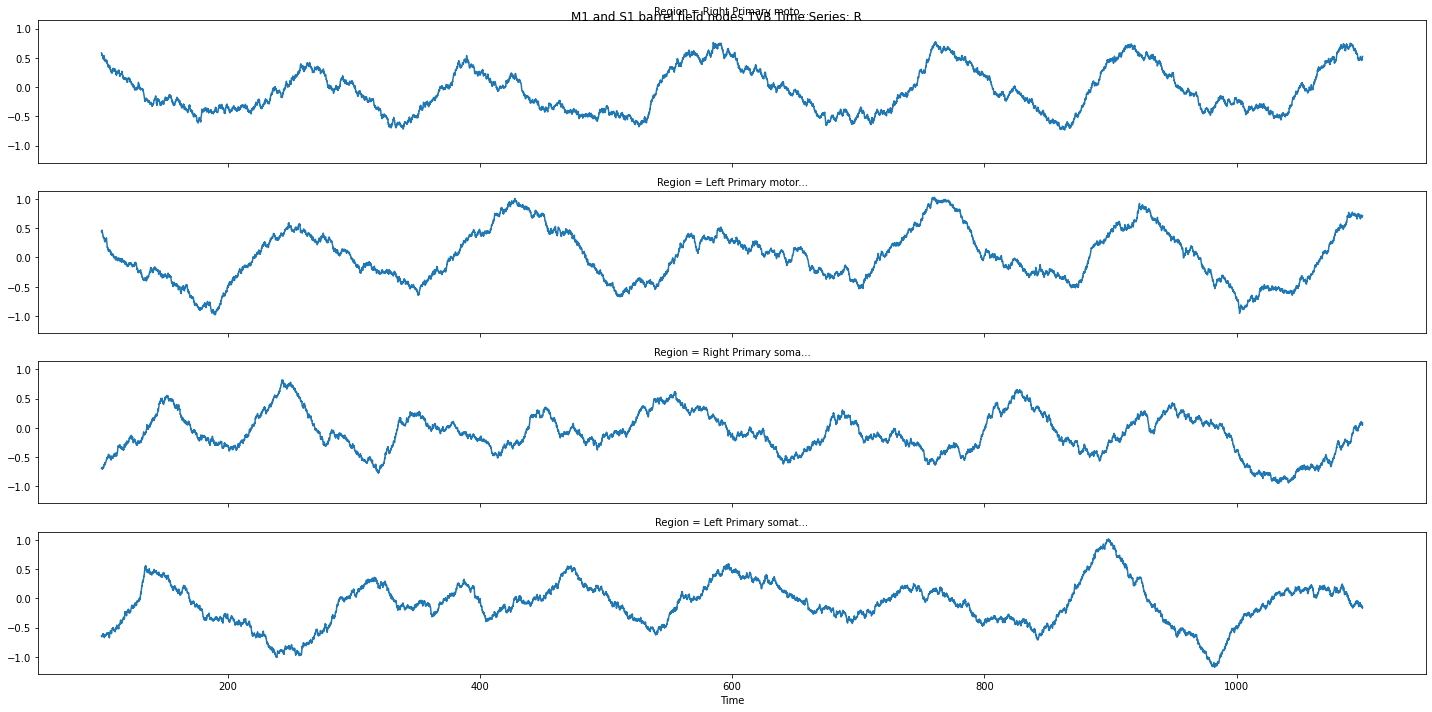

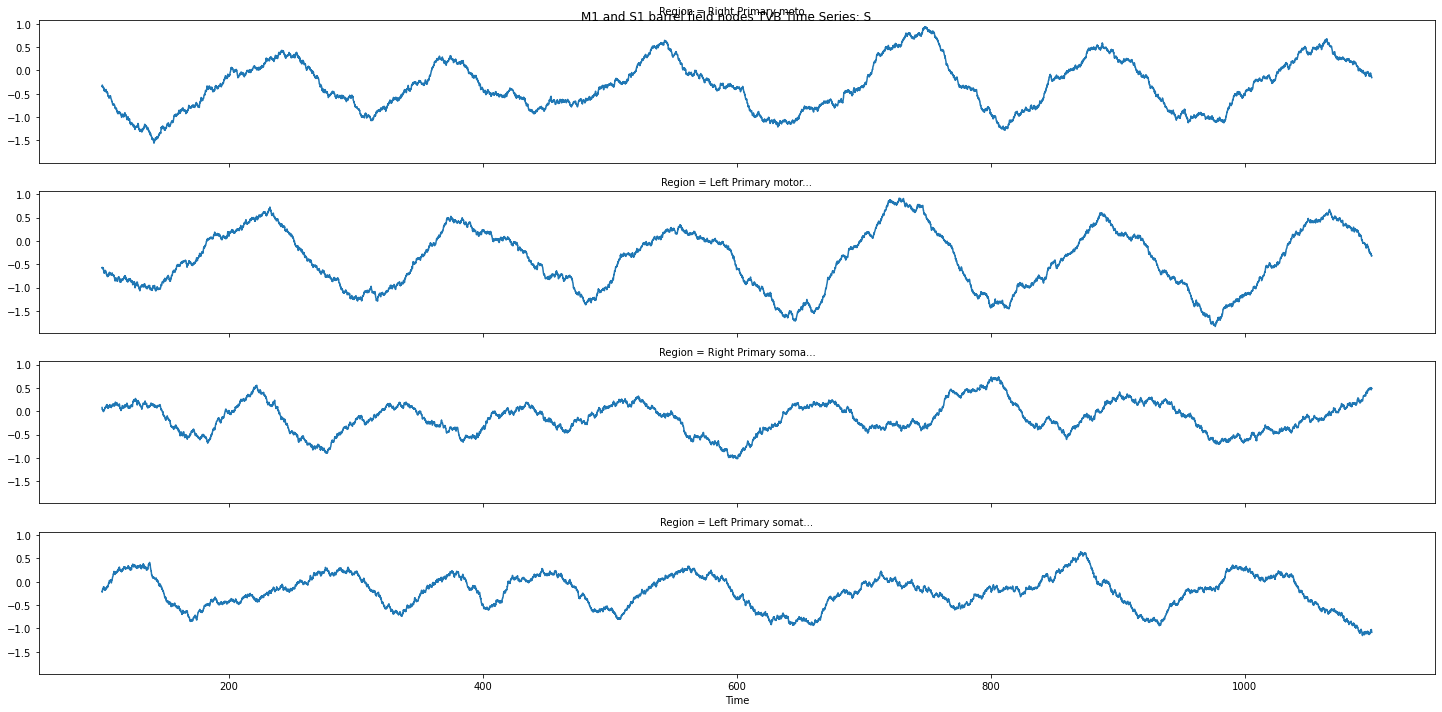

In [16]:
# Focus on the nodes modelled in NEST: 
if source_ts is not None:
    source_ts_m1s1brl = source_ts[-10000:, :, m1s1brl_inds]
    source_ts_m1s1brl.plot_timeseries(plotter_config=plotter.config, 
                                   hue="Region" if source_ts_m1s1brl.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                                   per_variable=source_ts_m1s1brl.shape[1] > MAX_VARS_IN_COLS, 
                                   figsize=FIGSIZE, figname="M1 and S1 barrel field nodes TVB Time Series");

In [17]:
# Focus on the nodes modelled in NEST: raster plot
if source_ts is not None and source_ts_m1s1brl.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
    source_ts_m1s1brl.plot_raster(plotter_config=plotter.config, 
                                  per_variable=source_ts_m1s1brl.shape[1] > MAX_VARS_IN_COLS,
                                  figsize=FIGSIZE, figname="M1 and S1 barrel field nodes TVB Time Series Raster");

2021-10-11 09:57:51,849 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-10-11 09:57:51,867 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-10-11 09:57:52,165 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  pyplot.gcf().canvas.set_window_title(figname)


2021-10-11 09:57:52,470 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  pyplot.gcf().canvas.set_window_title(figname)
/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  pyplot.gcf().canvas.set_window_title(figname)


2021-10-11 09:57:52,839 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  pyplot.gcf().canvas.set_window_title(figname)


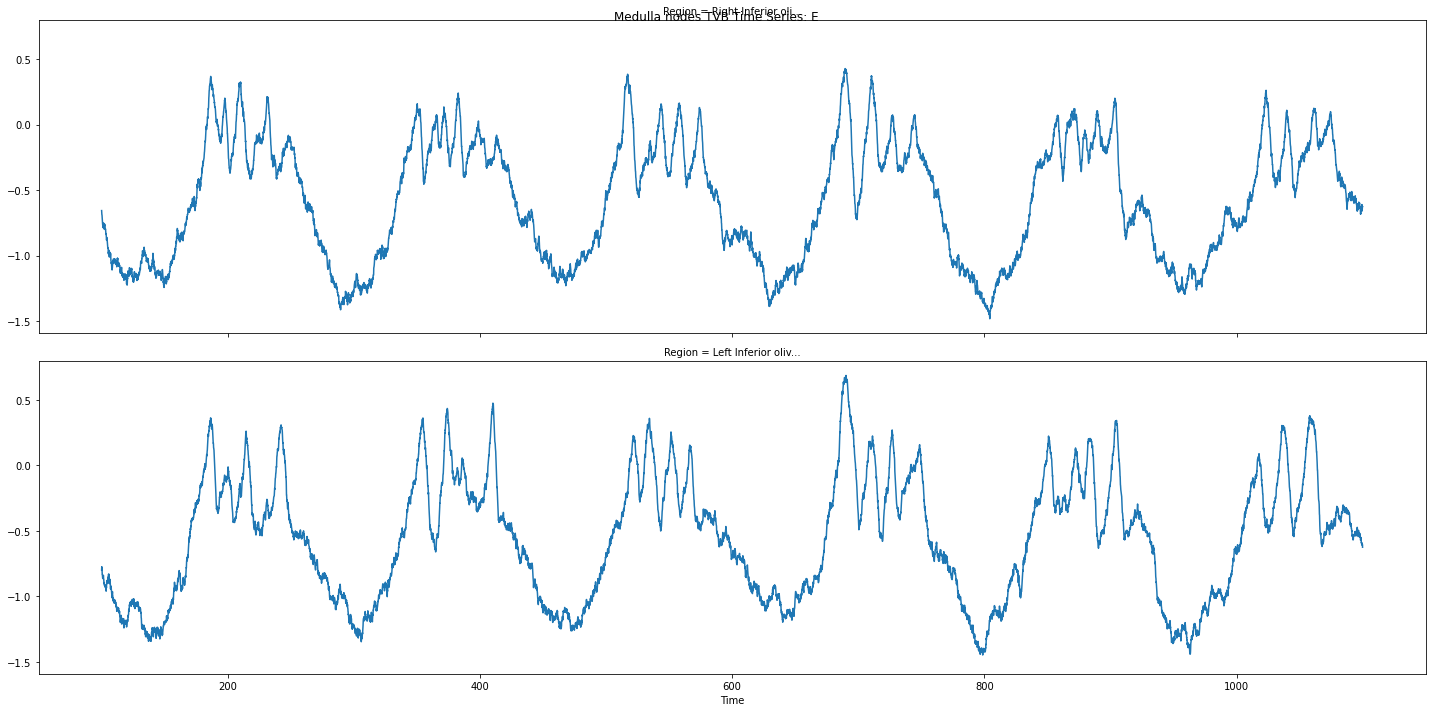

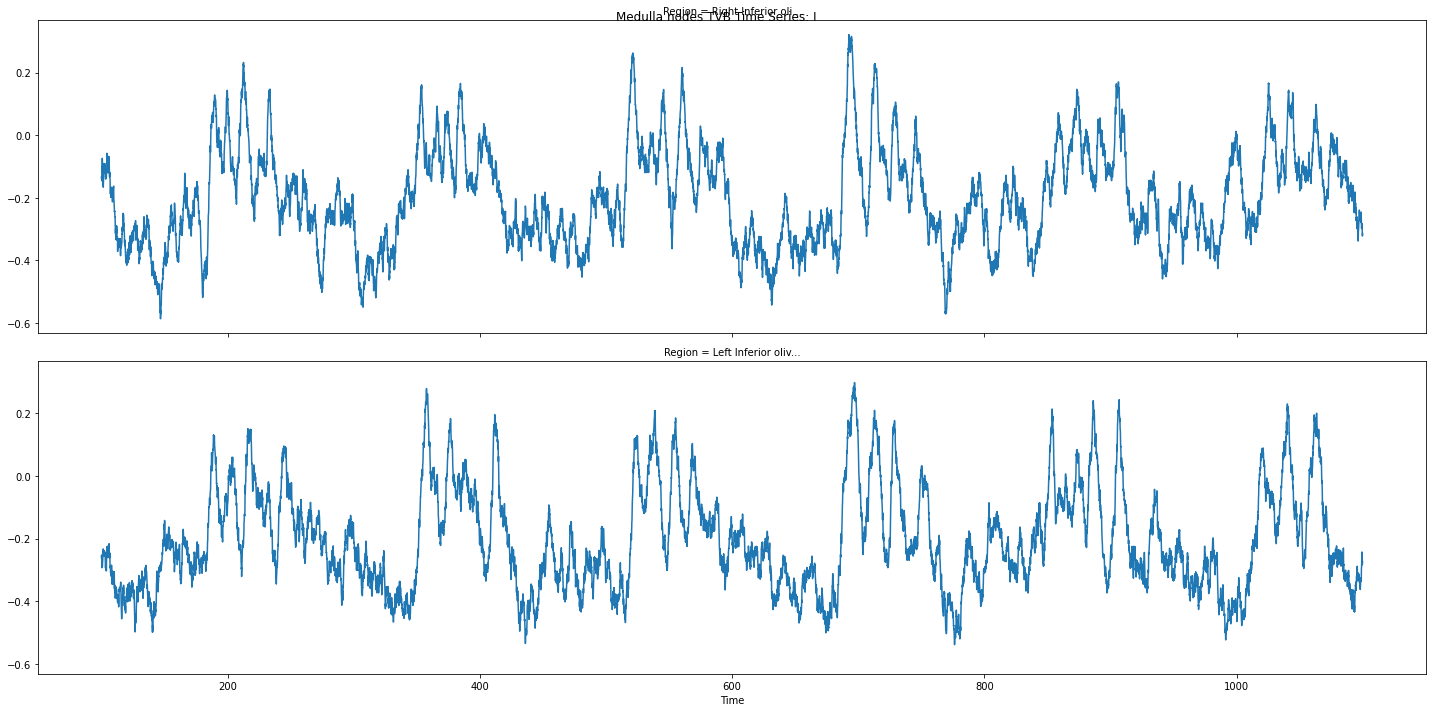

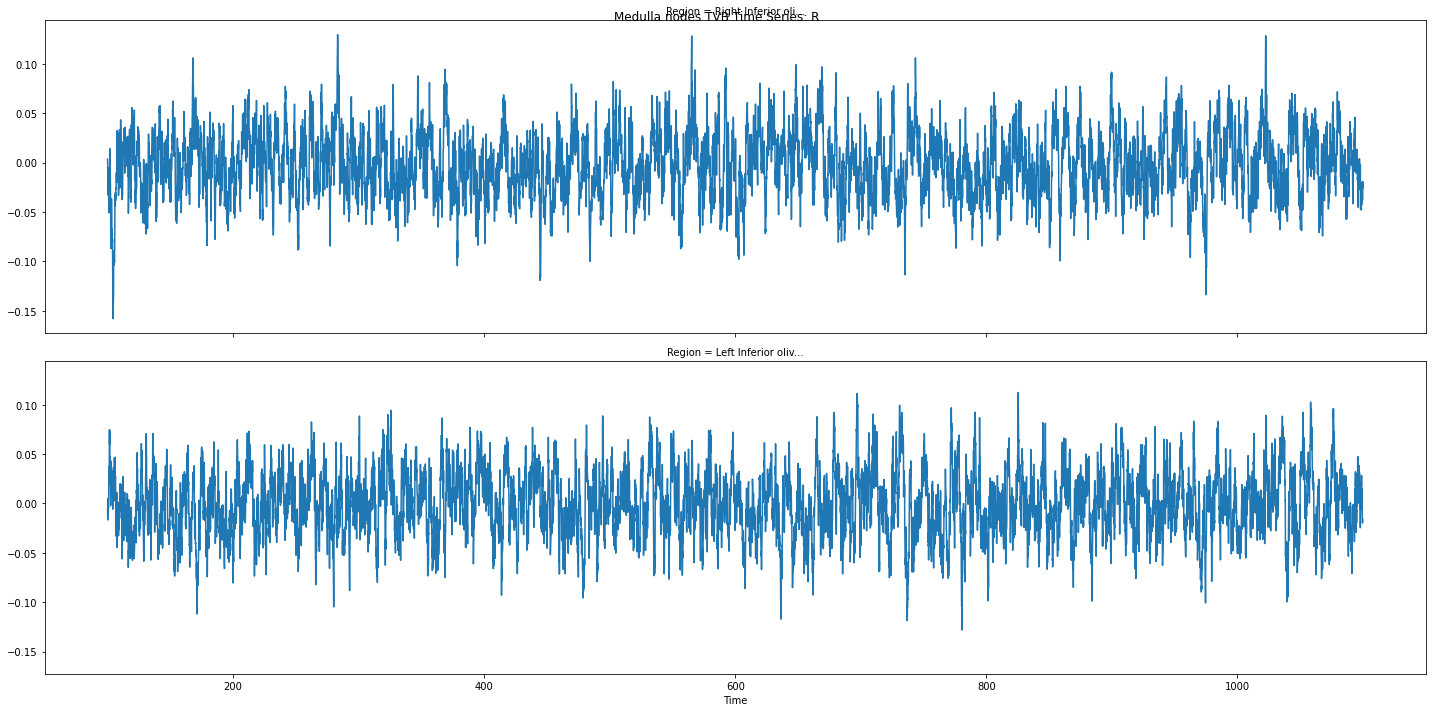

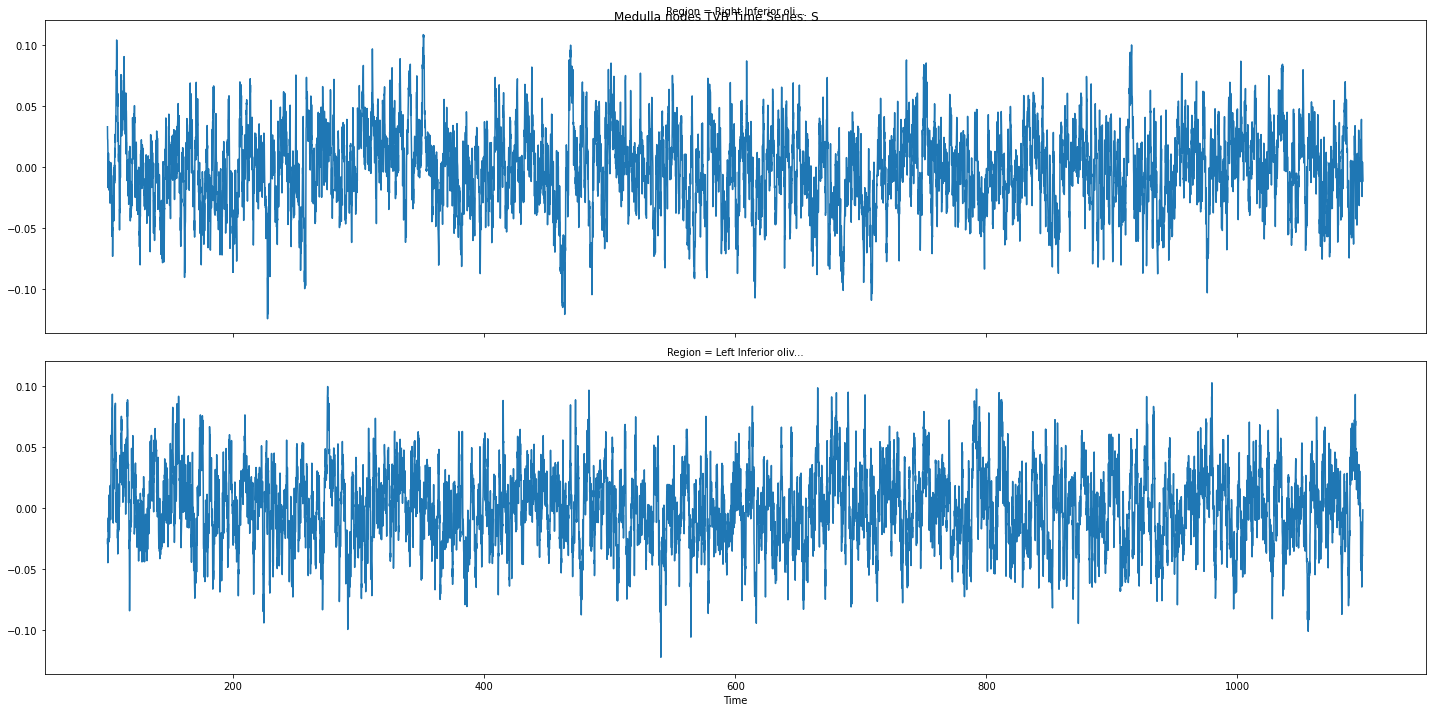

In [18]:
# Focus on the nodes modelled in NEST: 
if source_ts is not None:
    source_ts_medulla = source_ts[-10000:, :, medulla_inds]
    source_ts_medulla.plot_timeseries(plotter_config=plotter.config, 
                                   hue="Region" if source_ts_medulla.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                                   per_variable=source_ts_medulla.shape[1] > MAX_VARS_IN_COLS, 
                                   figsize=FIGSIZE, figname="Medulla nodes TVB Time Series");

In [19]:
# Focus on the nodes modelled in NEST: raster plot
if source_ts is not None and source_ts_medulla.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
    source_ts_medulla.plot_raster(plotter_config=plotter.config, 
                                  per_variable=source_ts_medulla.shape[1] > MAX_VARS_IN_COLS,
                                  figsize=FIGSIZE, figname="Medulla nodes TVB Time Series Raster");

In [20]:
# # Focus on the nodes modelled in NEST: 
# if source_ts is not None:
#     n_thal_regions = len(thal_inds)
#     source_ts_thal = source_ts[-10000:, :, thal_inds]
#     source_ts_thal.plot_timeseries(plotter_config=plotter.config, 
#                                    hue="Region" if source_ts_thal.shape[2] > MAX_REGIONS_IN_ROWS else None, 
#                                    per_variable=source_ts_thal.shape[1] > MAX_VARS_IN_COLS, 
#                                    figsize=FIGSIZE, figname="Thalamic nodes TVB Time Series");

### Interactive time series plot

In [21]:
# # ...interactively as well
# # For interactive plotting:
# %matplotlib notebook 
# plotter.plot_timeseries_interactive(source_ts)

In [22]:
import numpy
import pylab
import matplotlib.widgets as widgets
from tvb.simulator.common import get_logger
import tvb.datatypes.time_series as time_series_datatypes
from tvb.basic.neotraits.api import HasTraits, Attr, Int

LOG = get_logger(__name__)

# Define a colour theme... see: matplotlib.colors.cnames.keys()
BACKGROUNDCOLOUR = "slategrey"
EDGECOLOUR = "darkslateblue"
AXCOLOUR = "steelblue"
BUTTONCOLOUR = "steelblue"
HOVERCOLOUR = "blue"


class PowerSpectraInteractive(HasTraits):
    """
    The graphical interface for visualising the power-spectra (FFT) of a
    timeseries provide controls for setting:

        - which state-variable and mode to display [sets]
        - log or linear scaling for the power or frequency axis [binary]
        - sementation lenth [set]
        - windowing function [set]
        - power normalisation [binary] (emphasise relative frequency contribution)
        - show std or sem [binary]


    """

    time_series = Attr(
        field_type=time_series_datatypes.TimeSeries,
        label="Timeseries",
        default=None,
        doc=""" The timeseries to which the FFT is to be applied.""")

    first_n = Int(
        label="Display the first 'n'",
        default=0,
        doc="""Primarily intended for displaying the first N components of a 
            surface PCA timeseries. Defaults to -1, meaning it'll display all
            of 'space' (ie, regions or vertices or channels). In other words,
            for Region or M/EEG timeseries you can ignore this, but, for a 
            surface timeseries it really must be set.""")


    def __init__(self, **kwargs):
        """
        Initialise based on provided keywords or their traited defaults. Also,
        initialise the place-holder attributes that aren't filled until the
        show() method is called.

        """
        #figure
        self.fig = None

        #time-series
        self.psd_ax = None
        self.coh_ax = None
        
        #Current state
        self.xscale = "linear"
        self.yscale = "log"
        self.mode = 0
        self.variable = 0
        self.show_sem = False
        self.show_std = False
        self.normalise_power = "no"
        self.window_length = 0.25
        self.window_function = "None"

        #Selectors
        self.xscale_selector = None
        self.yscale_selector = None
        self.mode_selector = None
        self.variable_selector = None
        self.show_sem_selector = None
        self.show_std_selector = None
        self.normalise_power_selector = None
        self.window_length_selector = None
        self.window_function_selector = None

        #
        possible_freq_steps = [2**x for x in range(-2, 7)] #Hz
        #possible_freq_steps.append(1.0 / self.time_series_length) #Hz
        self.possible_window_lengths = 1.0 / numpy.array(possible_freq_steps) #s
        self.freq_step = 1.0 / self.window_length
        self.frequency = None
        self.spectra = None
        self.spectra_norm = None

        #Sliders
        #self.window_length_slider = None        
                
    def configure(self):
        """ Seperate configure cause ttraits be busted... """
        LOG.debug("time_series shape: %s" % str(self.time_series.data.shape))
        #TODO: if isinstance(self.time_series, TimeSeriesSurface) and self.first_n == -1: #LOG.error, return.
        if self.first_n == 0:
            first_n = None
        else:
            first_n = self.first_n
        self.data = self.time_series.data[:, :, :first_n, :]
        print('data.shape = %s'% str(self.data.shape))
        self.regions = np.arange(self.data.shape[2]).astype('i')
        self.reg_xy_inds = {}
        self.data_xy = []
        ii_xy = 0
        for reg1 in self.regions:
            for reg2 in range(reg1+1, self.regions[-1]+1):
                self.reg_xy_inds[(reg1, reg2)] = int(ii_xy)
                ii_xy += 1
                self.data_xy.append(self.data[:, :, reg1, :] * self.data[:, :, reg2, :])
        self.data_xy = np.array(self.data_xy).transpose(1, 2, 0, 3)
        self.reg_inds_sel = slice(0, self.regions.shape[0])
        self.reg_xy_inds_sel = np.arange(self.data_xy.shape[2]).astype('i')
        self.period = self.time_series.sample_period
        print("period = %g" % self.period)
        print("window_length = %g" % self.window_length)
        self.max_freq = 0.5 / (self.period / 1000)
        print("max_freq = %g" % self.max_freq)
        self.freq_step = 1.0 / (self.window_length / 1000)
        print("freq_step = %g" % self.freq_step)
        self.units = "Hz"
        self.tpts = self.data.shape[0]
        self.nsrs = self.data.shape[2]
        self.nsrs_xy = self.nsrs * (self.nsrs-1) / 2
        self.time_series_length = self.tpts * self.period
        print("time_series_length = %g" % self.time_series_length)
        self.time = numpy.arange(self.tpts) * self.period
        self.labels = ["channel_%0.3d" % k for k in range(self.nsrs)]


    def show(self):
        """ Generate the interactive power-spectra figure. """
        #Make sure everything is configured
        self.configure()

        #Make the figure:
        self.create_figure()

        #Selectors
        self.add_xscale_selector()
        self.add_freq_range_selector()
        self.add_yscale_selector()
        self.add_mode_selector()
        self.add_regions_selector()
        self.add_variable_selector()
        self.add_normalise_power_selector()
        self.add_window_length_selector()
        self.add_window_function_selector()
        
        #Sliders
        #self.add_window_length_slider() #Want discrete values
        #self.add_scaling_slider()

        #...
        self.calc_fft()

        #Plot timeseries
        self.plot_spectra()

        pylab.show()

    ##------------------------------------------------------------------------##
    ##------------------ Functions for building the figure -------------------##
    ##------------------------------------------------------------------------##
    def create_figure(self):
        """ Create the figure and time-series axes. """
        time_series_type = self.time_series.__class__.__name__
        try:
            figure_window_title = "Interactive power spectra: " + time_series_type
            pylab.close(figure_window_title)
            self.fig = pylab.figure(num = figure_window_title,
                                        figsize = (12, 8),
                                        facecolor = BACKGROUNDCOLOUR, 
                                        edgecolor = EDGECOLOUR)
        except ValueError:
            LOG.info("My life would be easier if you'd update your PyLab...")
            figure_number = 42
            pylab.close(figure_number)
            self.fig = pylab.figure(num = figure_number, 
                                         figsize = (12, 8), 
                                         facecolor = BACKGROUNDCOLOUR, 
                                         edgecolor = EDGECOLOUR)

        self.psd_ax = self.fig.add_axes([0.15, 0.6, 0.7, 0.3])
        self.coh_ax = self.fig.add_axes([0.15, 0.2, 0.7, 0.3])


    def add_xscale_selector(self):
        """
        Add a radio button to the figure for selecting which scaling the x-axes
        should use.
        """
        pos_shp = [0.25, 0.02, 0.05, 0.104]
        rax = self.fig.add_axes(pos_shp, facecolor=AXCOLOUR, title="xscale")
        xscale_tuple = ("log", "linear")
        self.xscale_selector = widgets.RadioButtons(rax, xscale_tuple, active=1)
        self.xscale_selector.on_clicked(self.update_xscale)
        
    def add_freq_range_selector(self):
        pos_shp = [0.65, 0.025, 0.05, 0.05]
        rax = self.fig.add_axes(pos_shp, facecolor=AXCOLOUR, title="Frequency range")
        text_box = widgets.TextBox(rax, '', initial="%g, " % 0.0)
        text_box.on_submit(self.update_freq_range)

    def add_yscale_selector(self):
        """
        Add a radio button to the figure for selecting which scaling the y-axes
        should use.
        """
        pos_shp = [0.02, 0.6, 0.05, 0.104]
        rax = self.fig.add_axes(pos_shp, facecolor=AXCOLOUR, title="yscale")
        yscale_tuple = ("log", "linear")
        self.yscale_selector = widgets.RadioButtons(rax, yscale_tuple, active=0)
        self.yscale_selector.on_clicked(self.update_yscale)


    def add_mode_selector(self):
        """
        Add a radio button to the figure for selecting which mode of the model
        should be displayed.
        """
        pos_shp = [0.02, 0.05, 0.05, 0.1+0.002*self.data.shape[3]]
        rax = self.fig.add_axes(pos_shp, facecolor=AXCOLOUR, title="Mode")
        mode_tuple = tuple(range(self.data.shape[3]))
        self.mode_selector = widgets.RadioButtons(rax, mode_tuple, active=0)
        self.mode_selector.on_clicked(self.update_mode)

        
    def add_regions_selector(self):
        pos_shp = [0.02, 0.225, 0.05, 0.05]
        rax = self.fig.add_axes(pos_shp, facecolor=AXCOLOUR, title="Regions")
        text_box = widgets.TextBox(rax, '', initial="%d:%d:%d" % (0, self.data.shape[2]-1, 1))
        text_box.on_submit(self.update_regions)

        
    def add_variable_selector(self):
        """
        Generate radio selector buttons to set which state variable is 
        displayed.
        """
        noc = self.data.shape[1] # number of choices
        #State variable for the x axis
        pos_shp = [0.02, 0.35, 0.05, 0.12+0.008*noc]
        rax = self.fig.add_axes(pos_shp, facecolor=AXCOLOUR, 
                                     title="state variable")
        self.variable_selector = widgets.RadioButtons(rax, tuple(range(noc)), 
                                                    active=0)
        self.variable_selector.on_clicked(self.update_variable)

        
    def add_window_length_selector(self):
        """
        Generate radio selector buttons to set the window length is seconds.
        """
        noc = self.possible_window_lengths.shape[0] # number of choices
        #State variable for the x axis
        pos_shp = [0.88, 0.07, 0.1, 0.12+0.02*noc]
        rax = self.fig.add_axes(pos_shp, facecolor=AXCOLOUR, 
                                     title="Segment length")
        wl_tup = tuple(self.possible_window_lengths)
        self.window_length_selector = widgets.RadioButtons(rax, wl_tup, active=4)
        self.window_length_selector.on_clicked(self.update_window_length)


    def add_window_function_selector(self):
        """
        Generate radio selector buttons to set the windowing function.
        """
        #TODO: add support for kaiser, requiers specification of beta.
        wf_tup = ("None", "hamming", "bartlett", "blackman", "hanning") 
        noc = len(wf_tup) # number of choices
        #State variable for the x axis
        pos_shp = [0.88, 0.77, 0.085, 0.12+0.01*noc]
        rax = self.fig.add_axes(pos_shp, facecolor=AXCOLOUR, 
                                    title="Windowing function")
        self.window_function_selector = widgets.RadioButtons(rax, wf_tup, active=0)
        self.window_function_selector.on_clicked(self.update_window_function)


    def add_normalise_power_selector(self):
        """
        Add a radio button to chose whether or not the power of all spectra 
        shouold be normalised to 1.
        """
        pos_shp = [0.02, 0.8, 0.05, 0.104]
        rax = self.fig.add_axes(pos_shp, facecolor=AXCOLOUR, title="normalise")
        np_tuple = ("yes", "no")
        self.normalise_power_selector = widgets.RadioButtons(rax, np_tuple, active=1)
        self.normalise_power_selector.on_clicked(self.update_normalise_power)


    ##------------------------------------------------------------------------##
    ##------------------ Functions for updating the state --------------------##
    ##------------------------------------------------------------------------##
    def calc_fft(self):
        """
        Calculate FFT using current state of the window_length, window_function,
        """
        #Segment time-series, overlapping if necessary
        nseg = int(numpy.ceil(self.time_series_length / self.window_length))
        print("nseg = \n%s" % str(nseg))
        if nseg != 1:
            seg_tpts = int(np.round(self.window_length / self.period))
            print("seg_tpts = \n%s" % str(seg_tpts))
            overlap = int(np.round(((seg_tpts * nseg) - self.tpts) / (nseg-1)))
            print("overlap = \n%s" % str(overlap))
            starts = [int(np.round(max(seg*(seg_tpts - overlap), 0)))
                          for seg in range(nseg)]
            segments = [self.data[start:start+seg_tpts] for start in starts] 
            segments = [segment[:, :, :, numpy.newaxis] for segment in segments]
            time_series = numpy.concatenate(segments, axis=4)
            segments_xy = [self.data_xy[start:start+seg_tpts] for start in starts] 
            segments_xy = [segment_xy[:, :, :, numpy.newaxis] for segment_xy in segments_xy]
            time_series_xy = numpy.concatenate(segments_xy, axis=4)
        else:
            time_series = self.data[:, :, :, :, numpy.newaxis]
            time_series_xy = self.data_xy[:, :, :, :, numpy.newaxis]
            seg_tpts = time_series.shape[0]

        #Base-line correct segmented time-series
        time_series = time_series - time_series.mean(axis=0)[numpy.newaxis, :]
        time_series_xy = time_series_xy - time_series_xy.mean(axis=0)[numpy.newaxis, :]

        #Apply windowing function
        if self.window_function != "None":
            window_function = eval("".join(("numpy.", self.window_function)))
            window_mask = numpy.reshape(window_function(seg_tpts), 
                                        (seg_tpts, 1, 1, 1, 1))
            time_series = time_series * window_mask
            time_series_xy = time_series_xy * window_mask

        #Calculate the FFT
        result =  numpy.fft.fft(time_series, axis=0)
        result_xy =  numpy.fft.fft(time_series_xy, axis=0)
        nfreq = int(np.round(len(result)/2))

        self.frequency = numpy.arange(0, self.max_freq, self.freq_step)
        self.plot_freqs_slice = slice(0, self.frequency.size)
        LOG.debug("frequency shape: %s" % str(self.frequency.shape))
        print("frequency shape: %s" % str(self.frequency.shape))
        
        self.spectra = numpy.mean(numpy.abs(result[1:nfreq+1])**2, axis=-1)
        LOG.debug("spectra shape: %s" % str(self.spectra.shape))
        print("spectra shape: %s" % str(self.spectra.shape))

        self.spectra_norm = (self.spectra / numpy.sum(self.spectra, axis=0))
        LOG.debug("spectra_norm shape: %s" % str(self.spectra_norm.shape))
        print("spectra_norm shape: %s" % str(self.spectra_norm.shape))
        
        spectra_norm_xy = numpy.mean(numpy.abs(result_xy[1:nfreq+1])**2, axis=-1) 
        spectra_norm_xy = (spectra_norm_xy / numpy.sum(spectra_norm_xy, axis=0))
        self.coherence = []
        for xy_inds, ii in self.reg_xy_inds.items():  
            self.coherence.append(
                    spectra_norm_xy[:, :, ii, :]**2 / 
                        (self.spectra_norm[:, :, xy_inds[0], :] * 
                         self.spectra_norm[:, :, xy_inds[1], :]),
                                )
        self.coherence = np.array(self.coherence).transpose(1, 2, 0, 3)
        LOG.debug("coherence shape: %s" % str(self.spectra.shape))

        #import pdb; pdb.set_trace()
#        self.spectra_std = numpy.std(numpy.abs(result[:nfreq]), axis=4)
#        self.spectra_sem = self.spectra_std / time_series.shape[4]

    ##------------------------------------------------------------------------##
    ##------------------ Functions for updating the figure -------------------##
    ##------------------------------------------------------------------------##
    def update_xscale(self, xscale):
        """ 
        Update the FFT axes' xscale to either log or linear based on radio
        button selection.
        """
        self.xscale = xscale
        self.psd_ax.set_xscale(self.xscale)
        self.coh_ax.set_xscale(self.xscale)
        pylab.draw()

    def _find_nearest(self, value):
        return (np.abs(self.frequency - value)).argmin()

    def update_freq_range(self, freq_range_text):
        if "," in freq_range_text:
            print(freq_range_text)
            freqs = freq_range_text.split(",")
            print(freqs)
            for iF, (new_freq, current_freq) in \
                enumerate(zip(freqs, [self.plot_freqs_slice.start, self.plot_freqs_slice.stop])):
                print(new_freq)
                if len(new_freq):
                    freqs[iF] = self._find_nearest(float(new_freq))
                else:
                    freqs[iF] = current_freq
                self.plot_freqs_slice = slice(freqs[0], freqs[1])
        else:
            if len(freq_range_text):
                freqs = float(freq_range_text)
                if freqs > 0.0:
                    self.plot_freqs_slice = slice(0, self._find_nearest(freqs))
                else:
                    self.plot_freqs_slice = slice(0, self.frequency.size)
        self.plot_spectra()
        
    def update_yscale(self, yscale):
        """ 
        Update the FFT axes' yscale to either log or linear based on radio
        button selection.
        """
        self.yscale = yscale
        self.psd_ax.set_yscale(self.yscale)
        self.coh_ax.set_yscale(self.yscale)
        pylab.draw()
                
    def update_mode(self, mode):
        """ Update the visualised mode based on radio button selection. """
        self.mode = mode
        self.plot_spectra()

    def _update_xy_regions(self):
        self.reg_xy_inds_sel = []
        ii_xy = 0
        for ir1, reg1 in enumerate(self.reg_inds_sel[:-1]):
            for reg2 in self.reg_inds_sel[ir1+1:]:
                self.reg_xy_inds_sel.append(self.reg_xy_inds[(reg1, reg2)])
        self.reg_xy_inds_sel = np.array(self.reg_xy_inds_sel).astype('i')
        
    def update_regions(self, regions_slice_text):
        """ Update the visualised regions based on radio button selection. """
        if ":" in regions_slice_text:
            regions_slice = regions_slice_text.split(":")
            start = None
            stop = None
            step = None
            if len(regions_slice) > 0:
                try:
                    start = int(regions_slice[0])
                except:
                    pass
                if len(regions_slice) > 1:
                    try:
                        stop = int(regions_slice[1])
                    except:
                        pass
                    if len(regions_slice) > 2:
                        try:
                            step = int(regions_slice[2])
                        except:
                            pass  
            self.reg_inds_sel = self.regions[slice(start, stop, step)]
        else:
            if len(regions_slice_text):
                self.reg_inds_sel = np.array(regions_slice_text.split(",")).astype('i')
        print("Indices of regions selected for plotting:\n%s" % str(self.reg_inds_sel))
        self._update_xy_regions()
        self.plot_spectra()
        

    def update_variable(self, variable):
        """ 
        Update state variable being plotted based on radio buttton selection.
        """
        self.variable = variable
        self.plot_spectra()


    def update_normalise_power(self, normalise_power):
        """ Update whether to normalise based on radio button selection. """
        self.normalise_power = normalise_power
        self.plot_spectra()


    def update_window_length(self, length):
        """
        Update timeseries window length based on the selected value.
        """
        #TODO: need this casting but not sure why, don't need int() with mode...
        self.window_length = numpy.float64(length) 
        #import pdb; pdb.set_trace()
        self.freq_step = 1.0 / self.window_length
        self.plot_spectra()


    def update_window_function(self, window_function):
        """
        Update windowing function based on the radio button selection.
        """
        self.window_function = window_function
        self.update_spectra()


    def update_spectra(self):
        """ Clear the axes and redraw the power-spectra. """
        self.calc_fft()
        self.plot_spectra()


#    def plot_std(self):
#        """ Plot """
#        std = (self.spectra[:, self.variable, :, self.mode] +
#               self.spectra_std[:, self.variable, :, self.mode])
#        self.psd_ax.plot(self.frequency, std, "--")
#    
#    
#    def plot_sem(self):
#        """  """
#        sem = (self.spectra[:, self.variable, :, self.mode] +
#               self.spectra_sem[:, self.variable, :, self.mode])
#        self.psd_ax.plot(self.frequency, sem, ":")


    def plot_spectra(self):
        """ Plot the power spectra. """
        self.psd_ax.clear()
        # Set title and axis labels
        time_series_type = self.time_series.__class__.__name__
        self.psd_ax.set(title = time_series_type)

        freqs = self.frequency[self.plot_freqs_slice]
        print("Frequency range for plotting: [%g, %g]" % (freqs[0], freqs[-1]))
        #import pdb; pdb.set_trace()
        #Plot the power spectra
        if self.normalise_power == "yes":
            self.psd_ax.clear()
            self.psd_ax.set(ylabel = "PSD")
            self.psd_ax.plot(freqs, self.spectra_norm[self.plot_freqs_slice, self.variable, 
                                                      self.reg_inds_sel, self.mode])
        else:
            self.psd_ax.clear()
            self.psd_ax.set(ylabel = "Power")
            self.psd_ax.plot(freqs, self.spectra[self.plot_freqs_slice, self.variable, 
                                                 self.reg_inds_sel, self.mode])
            
         # Set x and y scale based on curent radio button selection.
        self.psd_ax.set_xscale(self.xscale)
        self.psd_ax.set_yscale(self.yscale)

        if hasattr(self.psd_ax, 'autoscale'):
            self.psd_ax.autoscale(enable=True, axis='both', tight=True)
        
        self.coh_ax.clear()
        self.coh_ax.set(ylabel = "Coherence")
        self.coh_ax.set(xlabel = "Frequency (%s)" % self.units)
        if self.reg_xy_inds_sel.size:
            self.coh_ax.plot(freqs, 
                             self.coherence[self.plot_freqs_slice, self.variable, 
                                            self.reg_xy_inds_sel, self.mode])
        
         # Set x and y scale based on curent radio button selection.
        self.coh_ax.set_xscale(self.xscale)
        self.coh_ax.set_yscale(self.yscale)
        if hasattr(self.coh_ax, 'autoscale'):
            self.coh_ax.autoscale(enable=True, axis='both', tight=True)
            
#        #TODO: Need to ensure colour matching...
#        #If requested, add standard deviation
#        if self.show_std:
#            self.plot_std(self)
#            
#        #If requested, add standard error in mean
#        if self.show_sem:
#            self.plot_sem(self)

        pylab.draw()


2021-10-11 09:57:54,245 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
data.shape = (10000, 1, 4, 1)
period = 0.1
window_length = 1000
max_freq = 5000
freq_step = 1
time_series_length = 1000


<IPython.core.display.Javascript object>


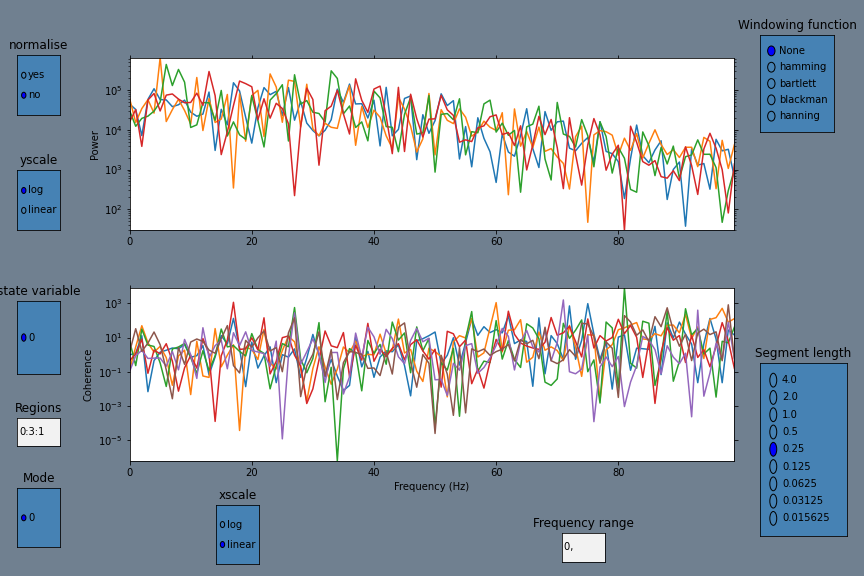

nseg = 
1
frequency shape: (5000,)
spectra shape: (5000, 1, 4, 1)
spectra_norm shape: (5000, 1, 4, 1)
Frequency range for plotting: [0, 4999]


Text(value='', description='start:stop:step', placeholder='Regions Slicer')

Text(value='', description='f_min, f_max', placeholder='Frequency Range')

0.0, 100.0
['0.0', ' 100.0']
0.0
 100.0
Frequency range for plotting: [0, 99]


In [23]:
# For interactive plotting:
%matplotlib notebook  

from tvb.datatypes.time_series import TimeSeries
# from tvb.simulator.plot.power_spectra_interactive import PowerSpectraInteractive

# [1000:, 0, thal_inds]
# [1000:, 0, crtx_inds]
tsr = TimeSeries(data=source_ts[1000:, 0, m1s1brl_inds]._data.values, sample_period=source_ts.sample_period)
psi = PowerSpectraInteractive()
psi.time_series = tsr
psi.window_length = 1000.0
psi.show()
from ipywidgets import interact, widgets as ip_widgets
from IPython.display import display

textRegions = ip_widgets.Text(
    value='',
    placeholder='Regions Slicer',
    description='start:stop:step',
    disabled=False
)

textFreqs = ip_widgets.Text(
    value='',
    placeholder='Frequency Range',
    description='f_min, f_max',
    disabled=False
)

def callbackRegions(wdgt):
    # replace by something useful
    psi.update_regions(wdgt.value)

def callbackFreqs(wdgt):
    # replace by something useful
    psi.update_freq_range(wdgt.value)
    
textRegions.on_submit(callbackRegions)
textFreqs.on_submit(callbackFreqs)

display(textRegions)
display(textFreqs)



# References

1 Paula Sanz Leon, Stuart A. Knock, M. Marmaduke Woodman, Lia Domide, <br>
  Jochen Mersmann, Anthony R. McIntosh, Viktor Jirsa (2013) <br>
  The Virtual Brain: a simulator of primate brain network dynamics. <br>
  Frontiers in Neuroinformatics (7:10. doi: 10.3389/fninf.2013.00010) <br>
  https://www.thevirtualbrain.org/tvb/zwei <br>
  https://github.com/the-virtual-brain <br>

2 Ritter P, Schirner M, McIntosh AR, Jirsa VK. 2013.  <br>
  The Virtual Brain integrates computational modeling  <br>
  and multimodal neuroimaging. Brain Connectivity 3:121–145. <br>

3 Jordan, Jakob; Mørk, Håkon; Vennemo, Stine Brekke;   Terhorst, Dennis; Peyser, <br>
  Alexander; Ippen, Tammo; Deepu, Rajalekshmi;   Eppler, Jochen Martin; <br>
  van Meegen, Alexander;   Kunkel, Susanne; Sinha, Ankur; Fardet, Tanguy; Diaz, <br>
  Sandra; Morrison, Abigail; Schenck, Wolfram; Dahmen, David;   Pronold, Jari; <br>
  Stapmanns, Jonas;   Trensch, Guido; Spreizer, Sebastian;   Mitchell, Jessica; <br>
  Graber, Steffen; Senk, Johanna; Linssen, Charl; Hahne, Jan; Serenko, Alexey; <br>
  Naoumenko, Daniel; Thomson, Eric;   Kitayama, Itaru; Berns, Sebastian;   <br>
  Plesser, Hans Ekkehard <br>
  NEST is a simulator for spiking neural network models that focuses <br>
  on the dynamics, size and structure of neural systems rather than on <br>
  the exact morphology of individual neurons. <br>
  For further information, visit http://www.nest-simulator.org. <br>
  The release notes for this release are available at  <br>
  https://github.com/nest/nest-simulator/releases/tag/v2.18.0 <br>

2021-10-11 09:57:54,833 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


<IPython.core.display.Javascript object>


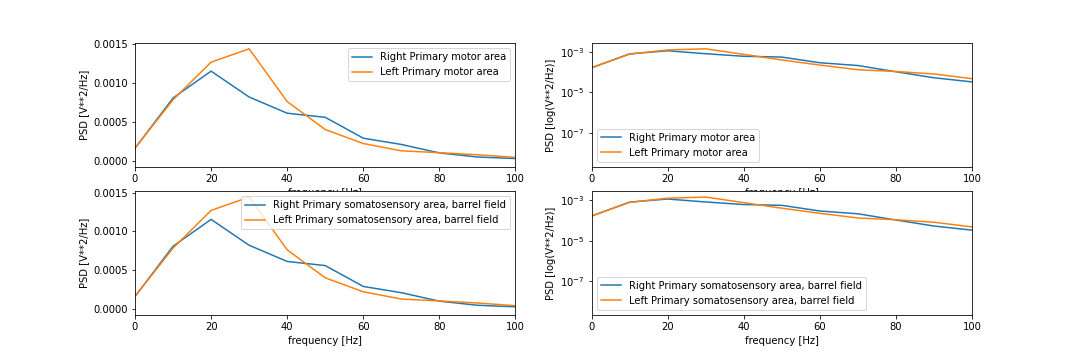

In [24]:
from scipy import signal
import matplotlib.pyplot as plt
data = source_ts[transient:, 0, m1s1brl_inds, 0].squeeze().T
fs = 1000/source_ts.sample_period
f, Pxx_den = signal.welch(data, fs, nperseg=1000)
fig, axes = plt.subplots(2,2, figsize=(15, 5))
axes[0, 0].plot(f, Pxx_den[0], label=connectivity.region_labels[m1s1brl_inds[0]])
axes[0, 0].plot(f, Pxx_den[1], label=connectivity.region_labels[m1s1brl_inds[1]])
axes[0, 0].set_xlim([0, 100])
axes[0, 0].set_xlabel('frequency [Hz]')
axes[0, 0].set_ylabel('PSD [V**2/Hz]')
axes[0, 0].legend()
axes[0, 1].semilogy(f, Pxx_den[0], label=connectivity.region_labels[m1s1brl_inds[0]])
axes[0, 1].semilogy(f, Pxx_den[1], label=connectivity.region_labels[m1s1brl_inds[1]])
axes[0, 1].set_xlim([0, 100])
axes[0, 1].set_xlabel('frequency [Hz]')
axes[0, 1].set_ylabel('PSD [log(V**2/Hz)]')
axes[0, 1].legend()
axes[1, 0].plot(f, Pxx_den[0], label=connectivity.region_labels[m1s1brl_inds[2]])
axes[1, 0].plot(f, Pxx_den[1], label=connectivity.region_labels[m1s1brl_inds[3]])
axes[1, 0].set_xlim([0, 100])
axes[1, 0].set_xlabel('frequency [Hz]')
axes[1, 0].set_ylabel('PSD [V**2/Hz]')
axes[1, 0].legend()
axes[1, 1].semilogy(f, Pxx_den[0], label=connectivity.region_labels[m1s1brl_inds[2]])
axes[1, 1].semilogy(f, Pxx_den[1], label=connectivity.region_labels[m1s1brl_inds[3]])
axes[1, 1].set_xlim([0, 100])
axes[1, 1].set_xlabel('frequency [Hz]')
axes[1, 1].set_ylabel('PSD [log(V**2/Hz)]')
axes[1, 1].legend()
# plt.ylim([1e-7, 1e2])
plt.show()


<IPython.core.display.Javascript object>


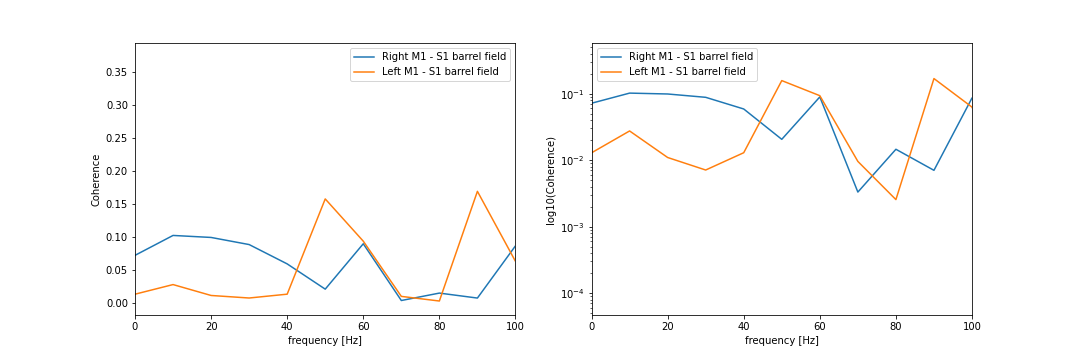

In [25]:
fR, CxyR = signal.coherence(data[0], data[1], fs, nperseg=1000)
fL, CxyL = signal.coherence(data[2], data[3], fs, nperseg=1000)
fig, axes = plt.subplots(1,2, figsize=(15, 5))
axes[0].plot(fR, CxyR.T, label="Right M1 - S1 barrel field")
axes[0].plot(fL, CxyL.T, label="Left M1 - S1 barrel field")
axes[0].set_xlim([0, 100])
axes[0].set_xlabel('frequency [Hz]')
axes[0].set_ylabel('Coherence')
axes[0].legend()
axes[1].semilogy(fR, CxyR.T, label="Right M1 - S1 barrel field")
axes[1].semilogy(fL, CxyL.T, label="Left M1 - S1 barrel field")
axes[1].set_xlim([0, 100])
axes[1].set_xlabel('frequency [Hz]')
axes[1].set_ylabel('log10(Coherence)')
axes[1].legend()

plt.show()

(11000, 144)


<IPython.core.display.Javascript object>


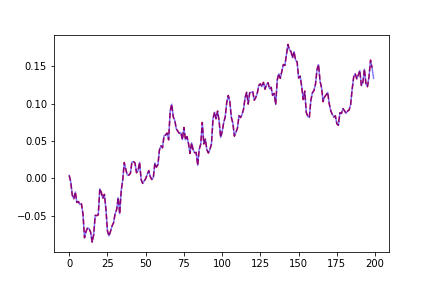

In [26]:
from matplotlib import pyplot as plt
SC_dels = np.concatenate(simulator.model._SC_dels, -1).T
print(SC_dels.shape)
plt.figure()
plt.plot(SC_dels[201:400, 0], 'r--')
plt.plot(source_ts.data[0:200, 3, 0, 0], 'b', alpha=0.5)

(11000, 144)


<IPython.core.display.Javascript object>


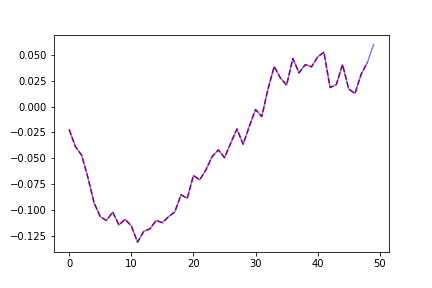

In [27]:
RS_dels = np.concatenate(simulator.model._RS_dels, -1).T
print(RS_dels.shape)
plt.figure()
plt.plot(RS_dels[51:100, 0], 'r--')
plt.plot(source_ts.data[0:50, 2, 0, 0], 'b', alpha=0.5)